# **Part 4: Quantifying Bias of the Models After Upsampling The Race**

In this final part of the study, we focus on assessing **the impact of racial upsampling** on the fairness of machine learning models. Unlike Part 3, where bias was evaluated using the original, imbalanced dataset, here we apply **upsampling techniques to equalize the representation of racial subgroups**—specifically between White and Non-White participants.

We then reevaluate the trained models across key demographic groups including **sex, race, device type, and dominant hand**, to understand how upsampling affects both predictive performance and fairness metrics. To quantify bias, we employ well-established measures such as **Disparate Impact, Equal Opportunity, and Equalized Odds Difference**, and compare group-level performance metrics such as **F1 Score, Sensitivity, Specificity, and AUC**.

This analysis helps determine whether upsampling underrepresented racial groups **solves the counter-intuitive results from Part 3** of the experiments and perform better for the privileged group.

### **Installing Libraries**

In [ ]:
!pip install aif360

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 5.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, recall_score
from sklearn.utils import resample
from collections import Counter

from aif360.datasets import BinaryLabelDataset

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive/')
    %cd '/content/drive/MyDrive/Parkinson Paper/'
    COLAB = True
    project_url = './'
except:
    COLAB = False
    project_url = './'

Mounted at /content/drive/


In [ ]:
data = pd.read_csv(f'{project_url}/data/final/dataset.csv', index_col=None)
data["Parkinson's Disease status"] = data["Parkinson's Disease status"].replace('suspectedpd', 'pd')

In [ ]:
def percent_with_num(values):
    def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}%\n({v:d})'.format(pct, v=val)
    return my_format

In [ ]:
print("Number of Records before Handling Missnig Values: ", data.shape[0])
print("Columns with null values:")
data.isnull().sum()

Number of Records before Handling Missnig Values:  266
Columns with null values:


Parkinson's Disease status                                                                                     5
Age                                                                                                            5
Gender                                                                                                         5
Race                                                                                                           5
M_deviation                                                                                                    0
                                                                                                              ..
Number of correctly pressed keys when prompted with a constant key with respect to average response time       0
Number of correctly pressed keys when prompted with a semi-random key with respect to average response time    0
Ratio_Points_Sine_Straight                                                                                     0
Ratio_Points_Spiral_Straight                                                                                   0
Ratio_Points_Sine_Spiral                                                                                       0
Length: 80, dtype: int64

In [ ]:
data = data.dropna()
print("Number of Records After Handling Missnig Values: ", data.shape[0])
print("Columns with null values:")
data.isnull().sum()


Number of Records After Handling Missnig Values:  251
Columns with null values:


Parkinson's Disease status                                                                                     0
Age                                                                                                            0
Gender                                                                                                         0
Race                                                                                                           0
M_deviation                                                                                                    0
                                                                                                              ..
Number of correctly pressed keys when prompted with a constant key with respect to average response time       0
Number of correctly pressed keys when prompted with a semi-random key with respect to average response time    0
Ratio_Points_Sine_Straight                                                                                     0
Ratio_Points_Spiral_Straight                                                                                   0
Ratio_Points_Sine_Spiral                                                                                       0
Length: 80, dtype: int64

## **Mapping Protected Attributes**

In [ ]:
race_mapping = {'White': "White", "Black or African American": "Others",
                "American Indian or Alaska Native": "Others"}

data.loc[:, 'Race'] = data['Race'].map(race_mapping)

gender_mapping = {'Male': 1.0, 'Female': 0.0}
race_mapping = {'White': 1.0, "Others": 0.0}
device_mapping = {"Windows Desktop": 0.0, "Mac Desktop": 1.0, "Linux Desktop": 0.0, "Desktop": 0.0}
dominantHand_mapping = {"Right": 1.0, "Left": 0.0}

data.loc[:, 'Sex_protected'] = data['Gender'].map(gender_mapping)
data.loc[:, 'Ethnicity_protected'] = data['Race'].map(race_mapping)
data.loc[:, 'Platform_protected'] = data['Device_type'].map(device_mapping)
data.loc[:, 'Preferred_hand_protected'] = data['Dominant_hand'].map(dominantHand_mapping)

<ipython-input-10-70cae8d46ed1>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, 'Sex_protected'] = data['Gender'].map(gender_mapping)
<ipython-input-10-70cae8d46ed1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, 'Ethnicity_protected'] = data['Race'].map(race_mapping)
<ipython-input-10-70cae8d46ed1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

### **Race Upsampling**

In [ ]:
from sklearn.utils import resample

white_majority = data[(data['Race'] == 'White') & (data["Parkinson's Disease status"] == 'nonpd')]
non_white_minority = data[(data['Race'] != 'White') & (data["Parkinson's Disease status"] == 'nonpd')]

non_white_minority_upsampled = resample(non_white_minority,
                                        replace=True,  # sample with replacement
                                        n_samples=len(white_majority),  # match majority class size
                                        random_state=42)

balanced_data = pd.concat([white_majority, non_white_minority_upsampled])
remaining_data = data[~((data['Race'] != 'White') & (data["Parkinson's Disease status"] == 'nonpd')) & ~((data['Race'] == 'White') & (data["Parkinson's Disease status"] == 'nonpd'))]

final_data = pd.concat([balanced_data, remaining_data])
final_data

Parkinson's Disease status   Age  Gender    Race  M_deviation  A_tcl  \
1                        nonpd  58.0    Male   White    -0.000934   1500   
3                        nonpd  61.0    Male   White     0.002205   1000   
5                        nonpd  62.0    Male   White    -0.000635   1500   
6                        nonpd  57.0    Male   White     0.006241   1000   
9                        nonpd  59.0    Male   White     0.002027   2500   
..                         ...   ...     ...     ...          ...    ...   
252                         pd  64.0  Female   White     0.016773   1500   
255                         pd  64.0  Female  Others     0.019522   3000   
256                         pd  67.0    Male   White    -0.025190   1000   
261                         pd  64.0    Male  Others     0.005400   3000   
265                         pd  55.0    Male     NaN    -0.002017   3000   

      A_tslww     P_isl  N_tislnt  A_tsw  ...  \
1    1.169135  1.000000         3   3500  ...   
3    0.779423  1.000000         2   3500  ...   
5    1.169135  1.000000         3   3500  ...   
6    0.779423  1.000000         2   4500  ...   
9    1.472320  1.000000         5   6000  ...   
..        ...       ...       ...    ...  ...   
252  1.041667  1.000000         3   2500  ...   
255  2.343750  0.833333         5   5000  ...   
256  0.694444  1.000000         2   1500  ...   
261  2.196193  1.000000         6  15500  ...   
265  2.343750  1.000000         6  12000  ...   

     Interaction_Time_Spiral_False_presses  \
1                                     2000   
3                                        0   
5                                        0   
6                                        0   
9                                    20000   
..                                     ...   
252                                      0   
255                                  12000   
256                                   2000   
261                                      0   
265                                   7500   

     Number of correctly pressed keys when prompted with a constant key with respect to average response time  \
1                                             0.001791                                                          
3                                             0.001790                                                          
5                                             0.001425                                                          
6                                             0.001421                                                          
9                                             0.000000                                                          
..                                                 ...                                                          
252                                           0.017527                                                          
255                                           0.007573                                                          
256                                           0.012220                                                          
261                                           0.000636                                                          
265                                           0.003261                                                          

     Number of correctly pressed keys when prompted with a semi-random key with respect to average response time  \
1                                             0.002354                                                             
3                                             0.000456                                                             
5                                             0.002354                                                             
6                                             0.001179                                                             
9           

### **Data Preprocessing and Exploratory Analysis**

In [ ]:
final_data = final_data.dropna()
final_data.isna().sum().sum()

0

In [ ]:
final_data = final_data[final_data['Device_type'] != 'Linux Desktop']
final_data = final_data[final_data['Device_type'] != 'Desktop']
final_data

Parkinson's Disease status   Age  Gender    Race  M_deviation  A_tcl  \
1                        nonpd  58.0    Male   White    -0.000934   1500   
3                        nonpd  61.0    Male   White     0.002205   1000   
5                        nonpd  62.0    Male   White    -0.000635   1500   
6                        nonpd  57.0    Male   White     0.006241   1000   
10                       nonpd  62.0    Male   White     0.001656   2000   
..                         ...   ...     ...     ...          ...    ...   
251                         pd  30.0    Male  Others     0.024531   2000   
252                         pd  64.0  Female   White     0.016773   1500   
255                         pd  64.0  Female  Others     0.019522   3000   
256                         pd  67.0    Male   White    -0.025190   1000   
261                         pd  64.0    Male  Others     0.005400   3000   

      A_tslww     P_isl  N_tislnt  A_tsw  ...  \
1    1.169135  1.000000         3   3500  ...   
3    0.779423  1.000000         2   3500  ...   
5    1.169135  1.000000         3   3500  ...   
6    0.779423  1.000000         2   4500  ...   
10   2.042901  1.000000         4   9500  ...   
..        ...       ...       ...    ...  ...   
251  1.562500  1.000000         4  10000  ...   
252  1.041667  1.000000         3   2500  ...   
255  2.343750  0.833333         5   5000  ...   
256  0.694444  1.000000         2   1500  ...   
261  2.196193  1.000000         6  15500  ...   

     Interaction_Time_Spiral_False_presses  \
1                                     2000   
3                                        0   
5                                        0   
6                                        0   
10                                   39000   
..                                     ...   
251                                 725000   
252                                      0   
255                                  12000   
256                                   2000   
261                                      0   

     Number of correctly pressed keys when prompted with a constant key with respect to average response time  \
1                                             0.001791                                                          
3                                             0.001790                                                          
5                                             0.001425                                                          
6                                             0.001421                                                          
10                                            0.004058                                                          
..                                                 ...                                                          
251                                           0.013798                                                          
252                                           0.017527                                                          
255                                           0.007573                                                          
256                                           0.012220                                                          
261                                           0.000636                                                          

     Number of correctly pressed keys when prompted with a semi-random key with respect to average response time  \
1                                             0.002354                                                             
3                                             0.000456                                                             
5                                             0.002354                                                             
6                                             0.001179                                                             
10          

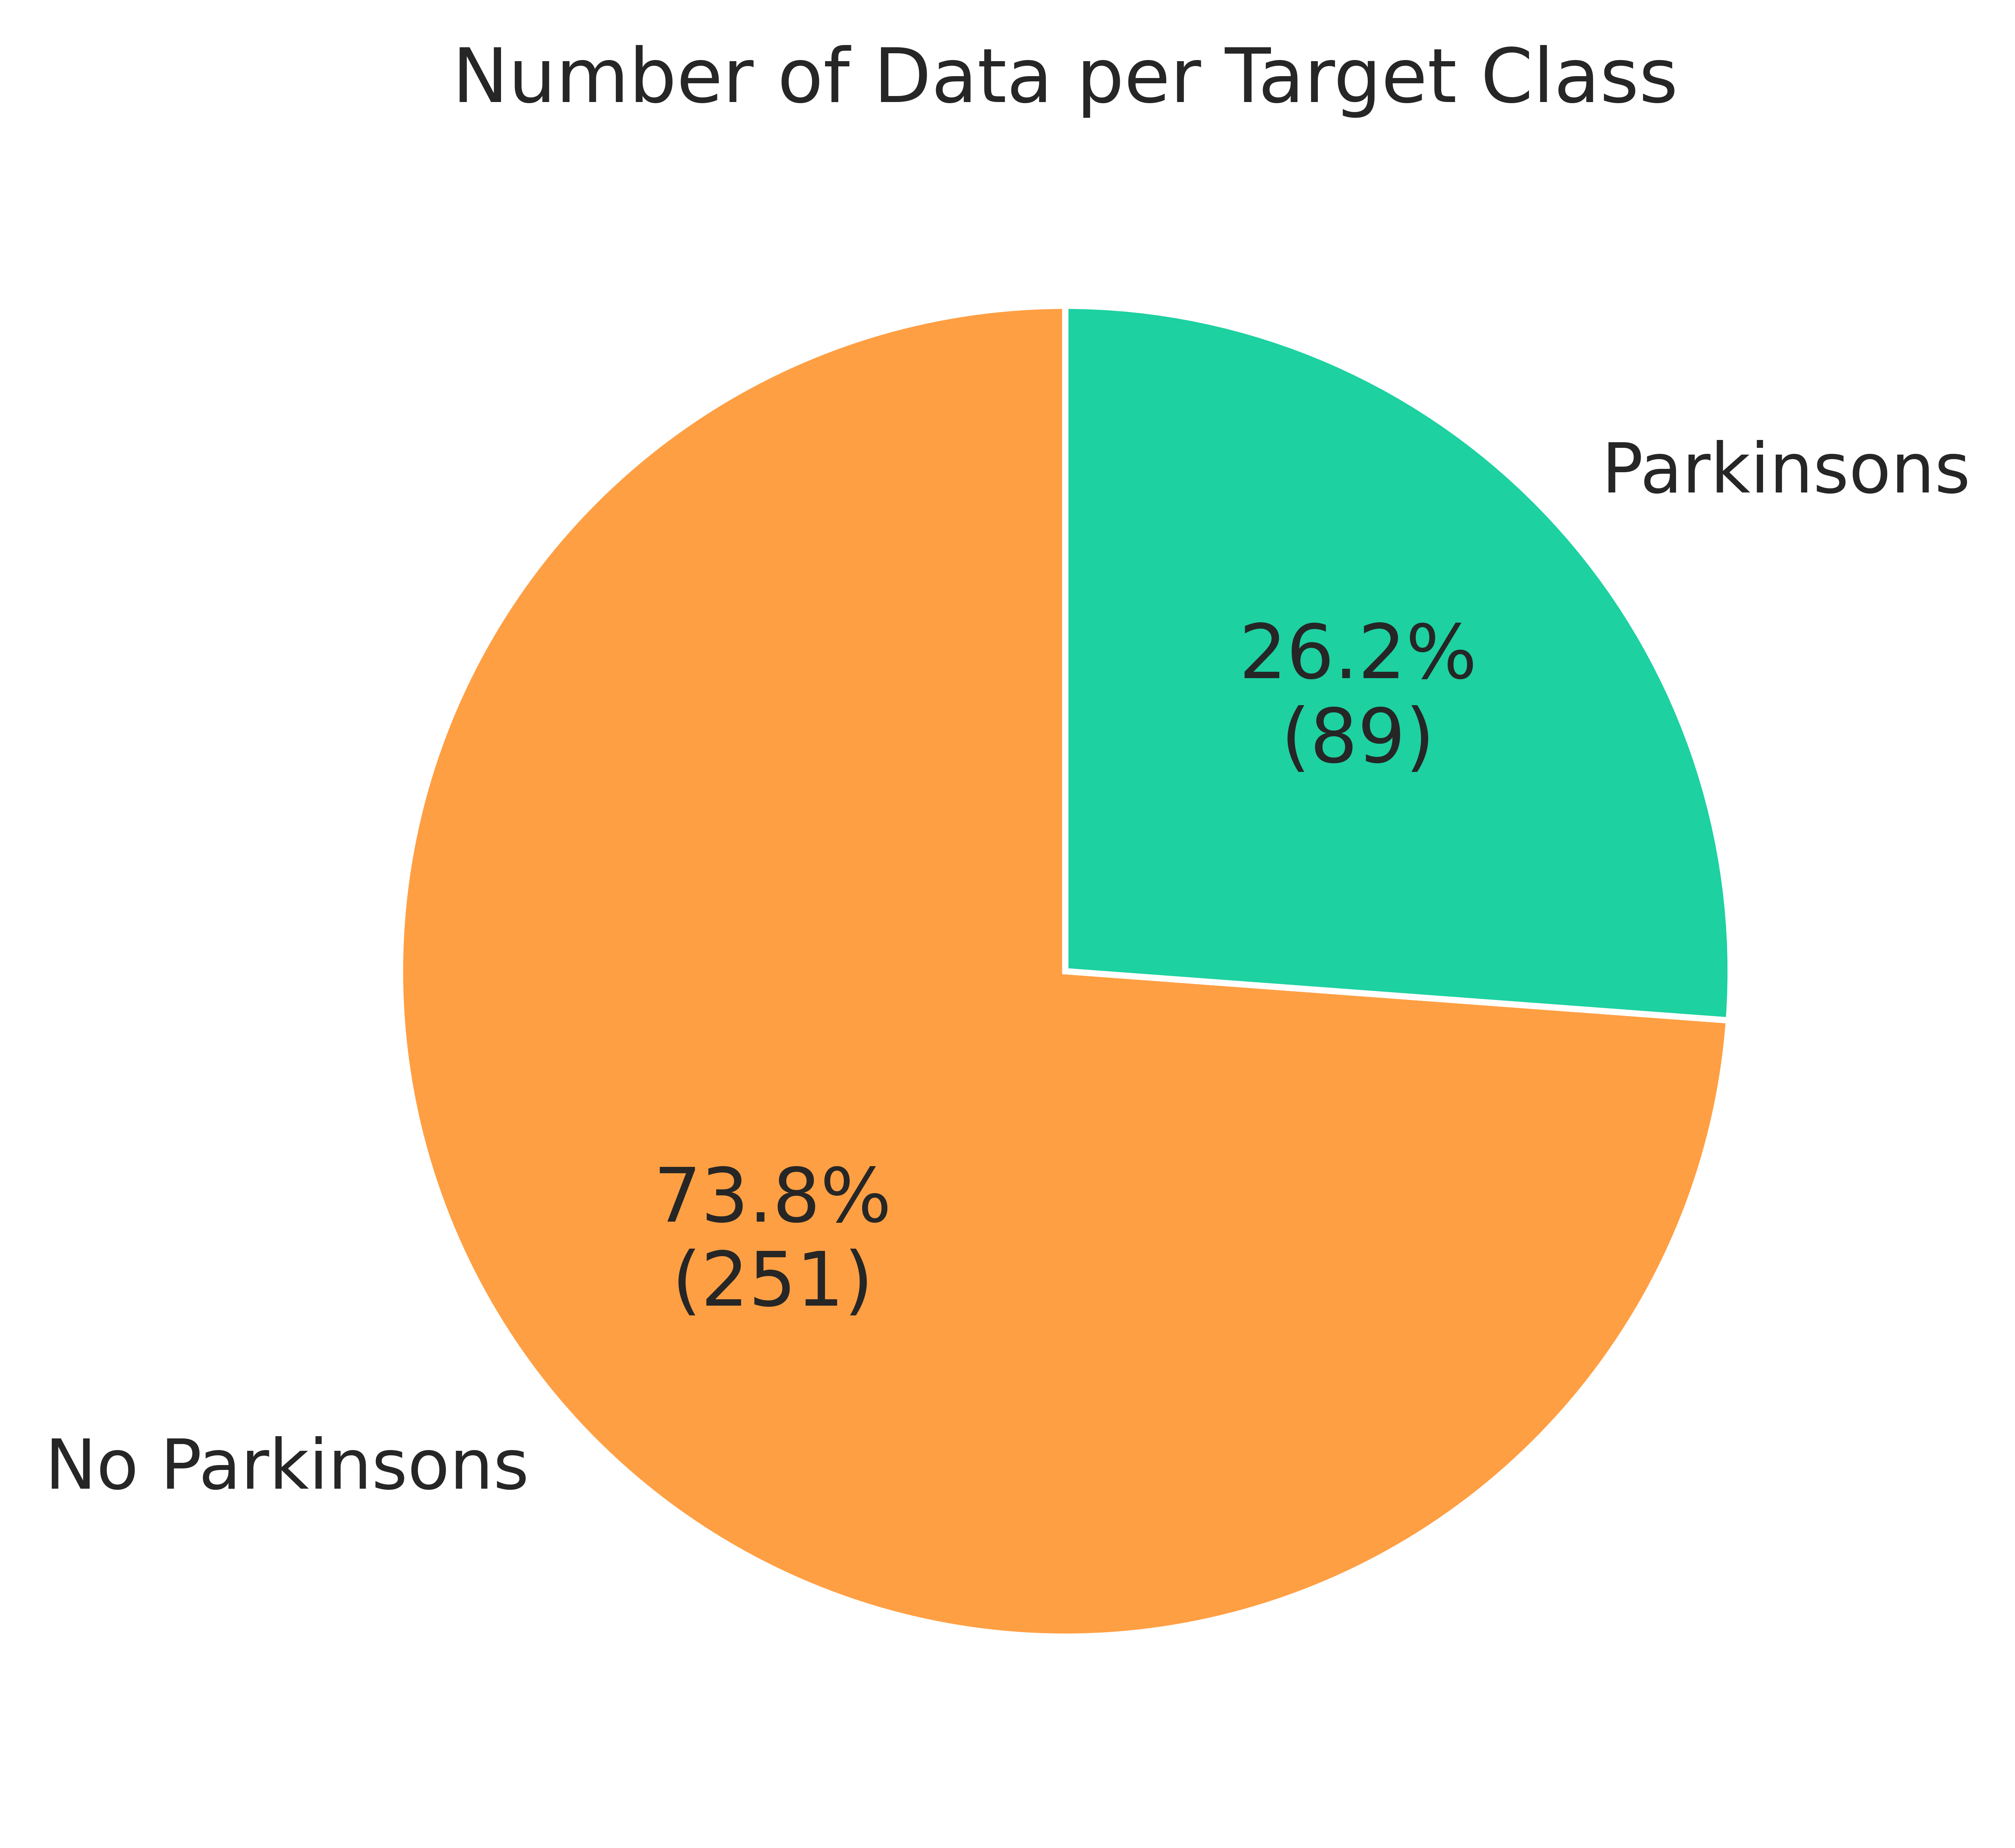

In [ ]:
sns.set()

plt.figure(dpi=1200)
counts = final_data["Parkinson's Disease status"].value_counts()
counts = counts.rename(index={"pd": "Parkinsons", "nonpd": "No Parkinsons"})
plt.pie(counts, labels=counts.index, autopct=percent_with_num(counts), startangle=90, colors=["#ff9f43", "#1dd1a1"])
plt.title("Number of Data per Target Class")

sns.set_style("whitegrid")
sns.despine()
plt.show()

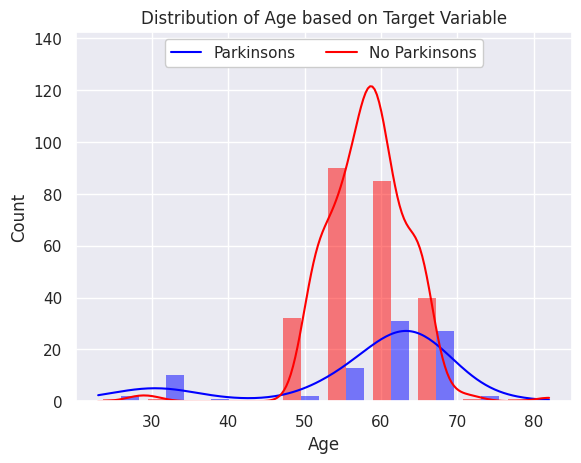

In [ ]:
sns.set()

sns.histplot(data=final_data, x='Age', hue="Parkinson's Disease status", multiple='dodge', shrink=0.8, kde=True, linewidth=0, bins=10, palette=["red", "blue"])
plt.legend(["Parkinsons", "No Parkinsons"], loc=9, facecolor='white', framealpha=1, ncol=2)
plt.title('Distribution of Age based on Target Variable')
plt.xlabel('Age')
plt.ylabel('Count')

x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,y1,y2 + 15))

plt.show()

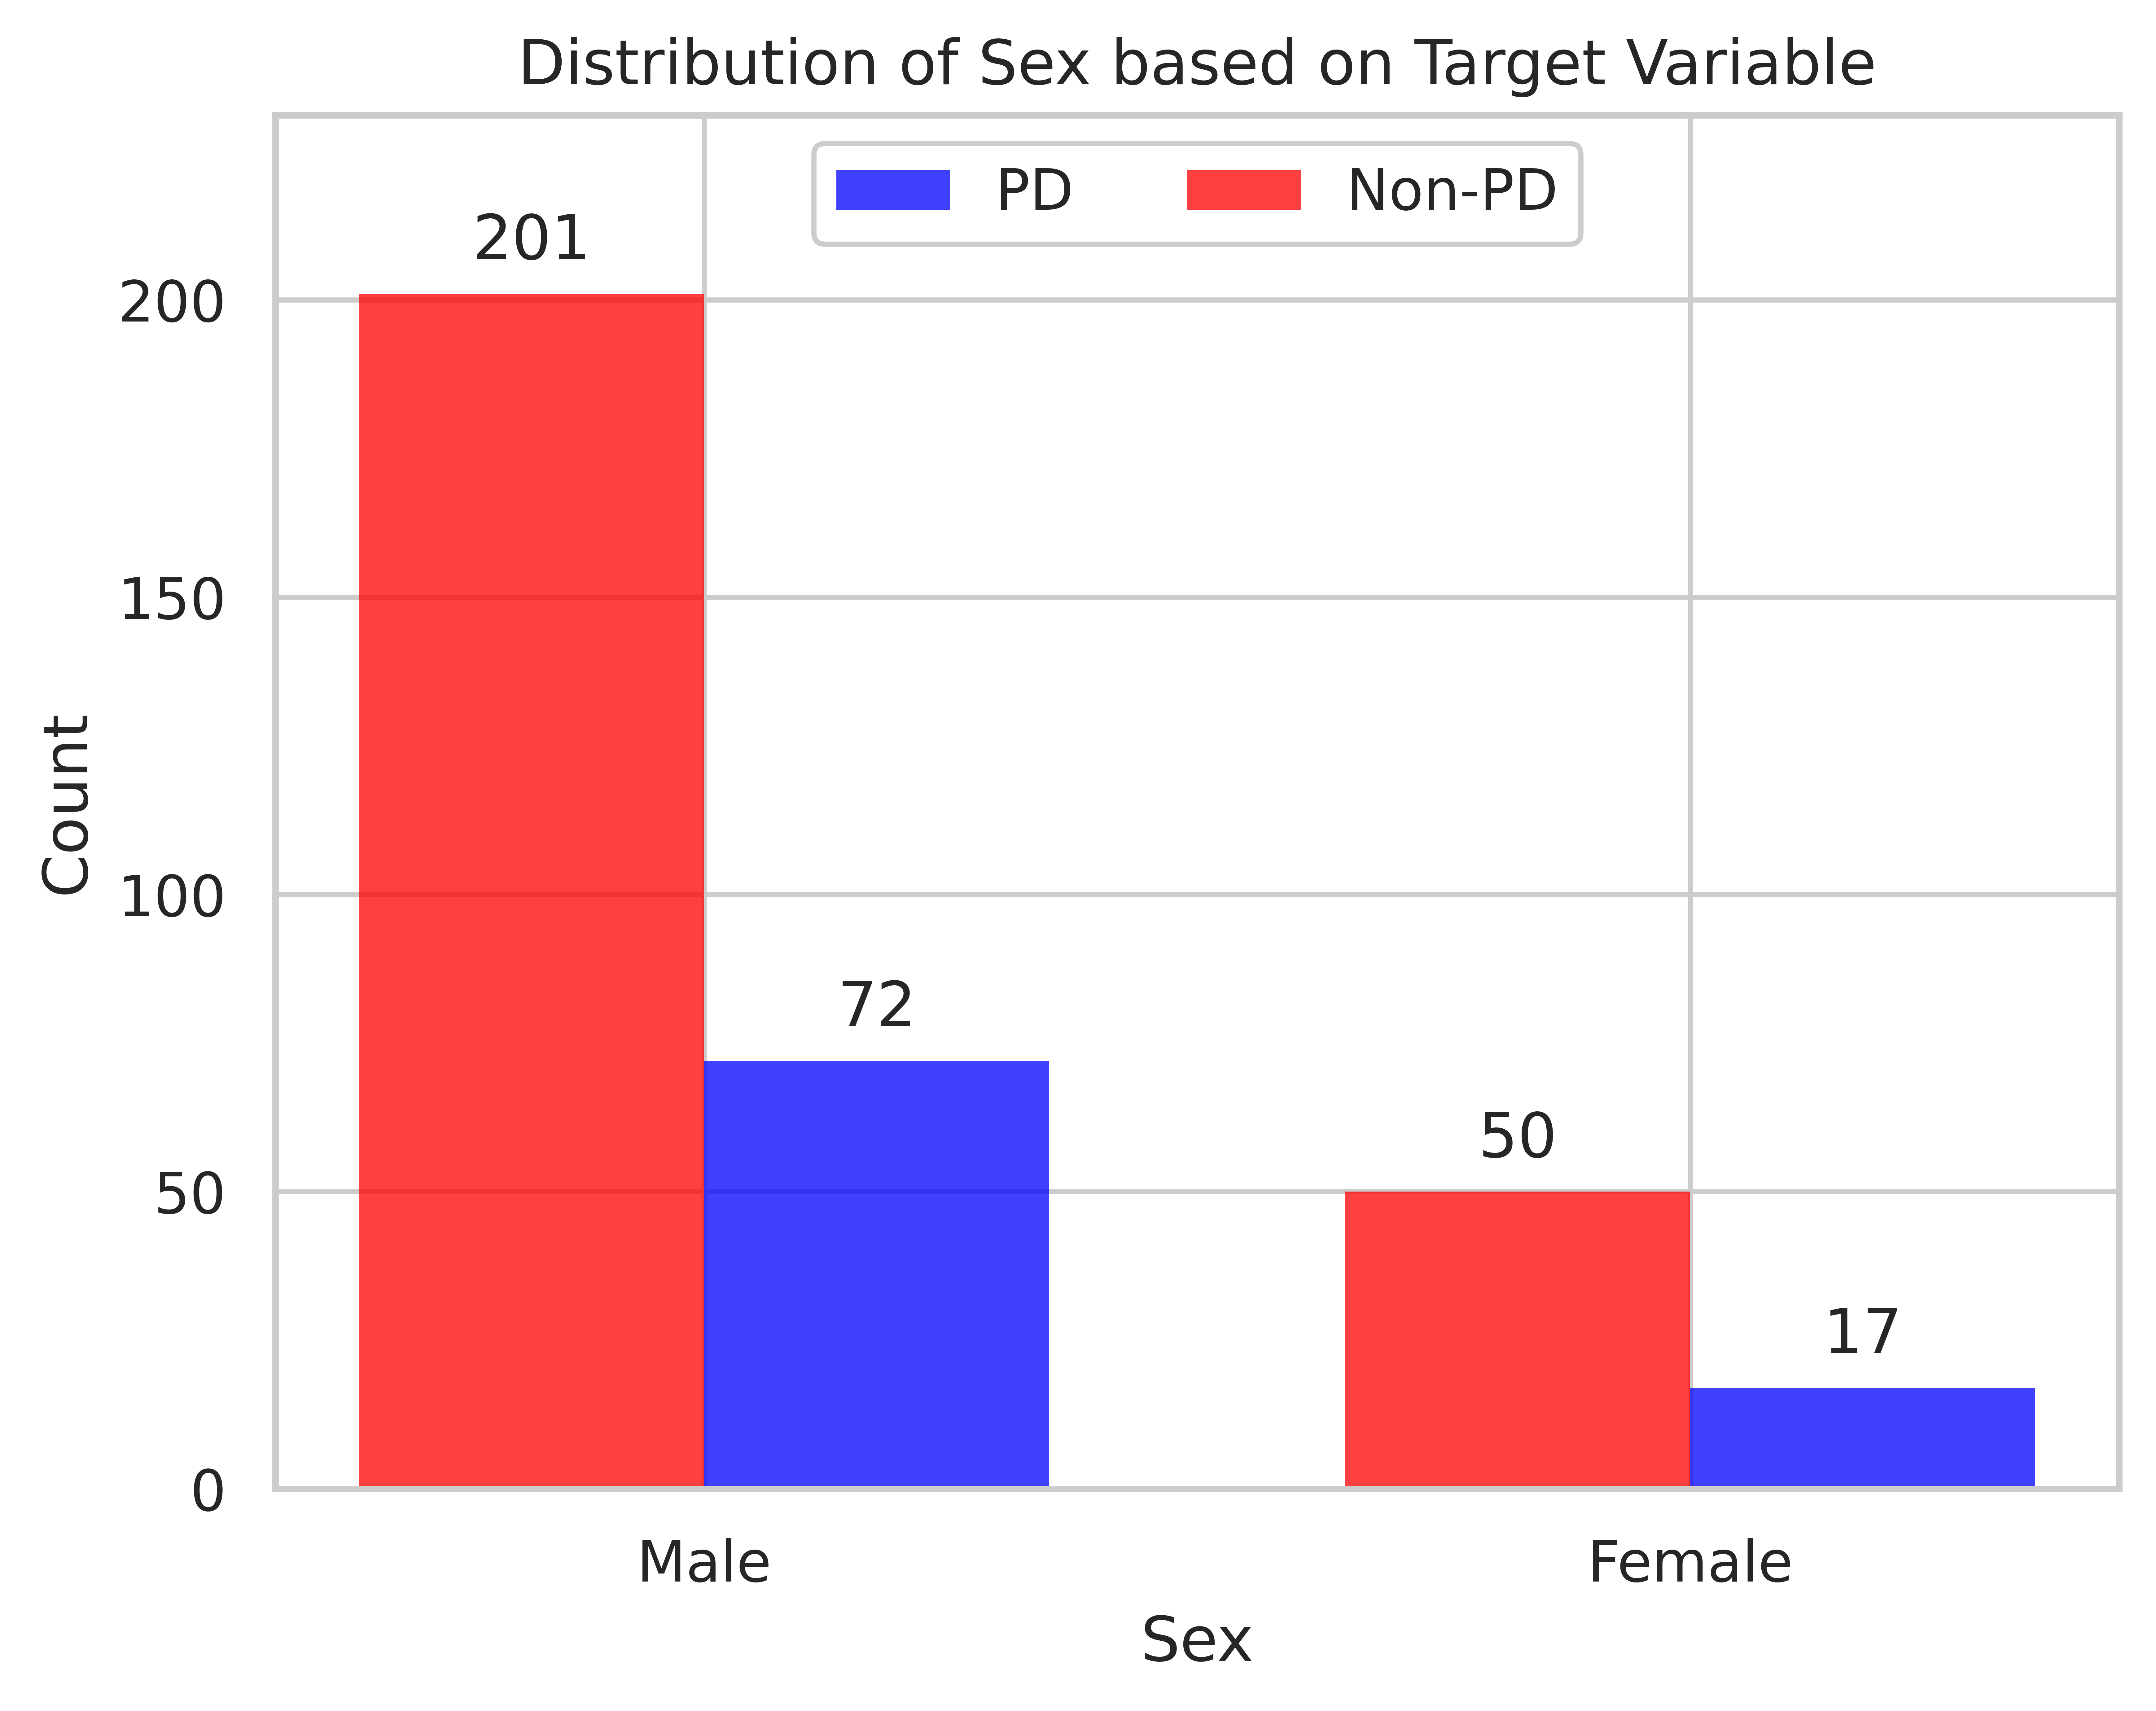

In [ ]:
plt.figure(dpi=1200)
ax = sns.histplot(data=final_data, x='Gender', hue="Parkinson's Disease status", shrink=0.7, multiple='dodge', linewidth=0, bins=10, palette=["red", "blue"])
plt.title('Distribution of Sex based on Target Variable')
plt.legend(["PD", "Non-PD"], loc=9, facecolor='white', framealpha=1, ncol=2)
plt.xlabel('Sex')
plt.ylabel('Count')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10),
                textcoords='offset points')

x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,y1,y2 + 20))
plt.show()

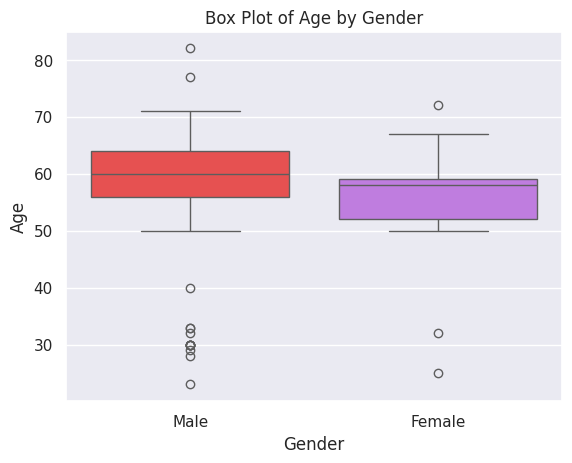

In [ ]:
sns.boxplot(x='Gender', y='Age', hue='Gender', data=final_data, palette=["#ff3838", "#c56cf0"])
plt.title('Box Plot of Age by Gender')
plt.xlabel('Gender')
plt.ylabel('Age')

plt.show()

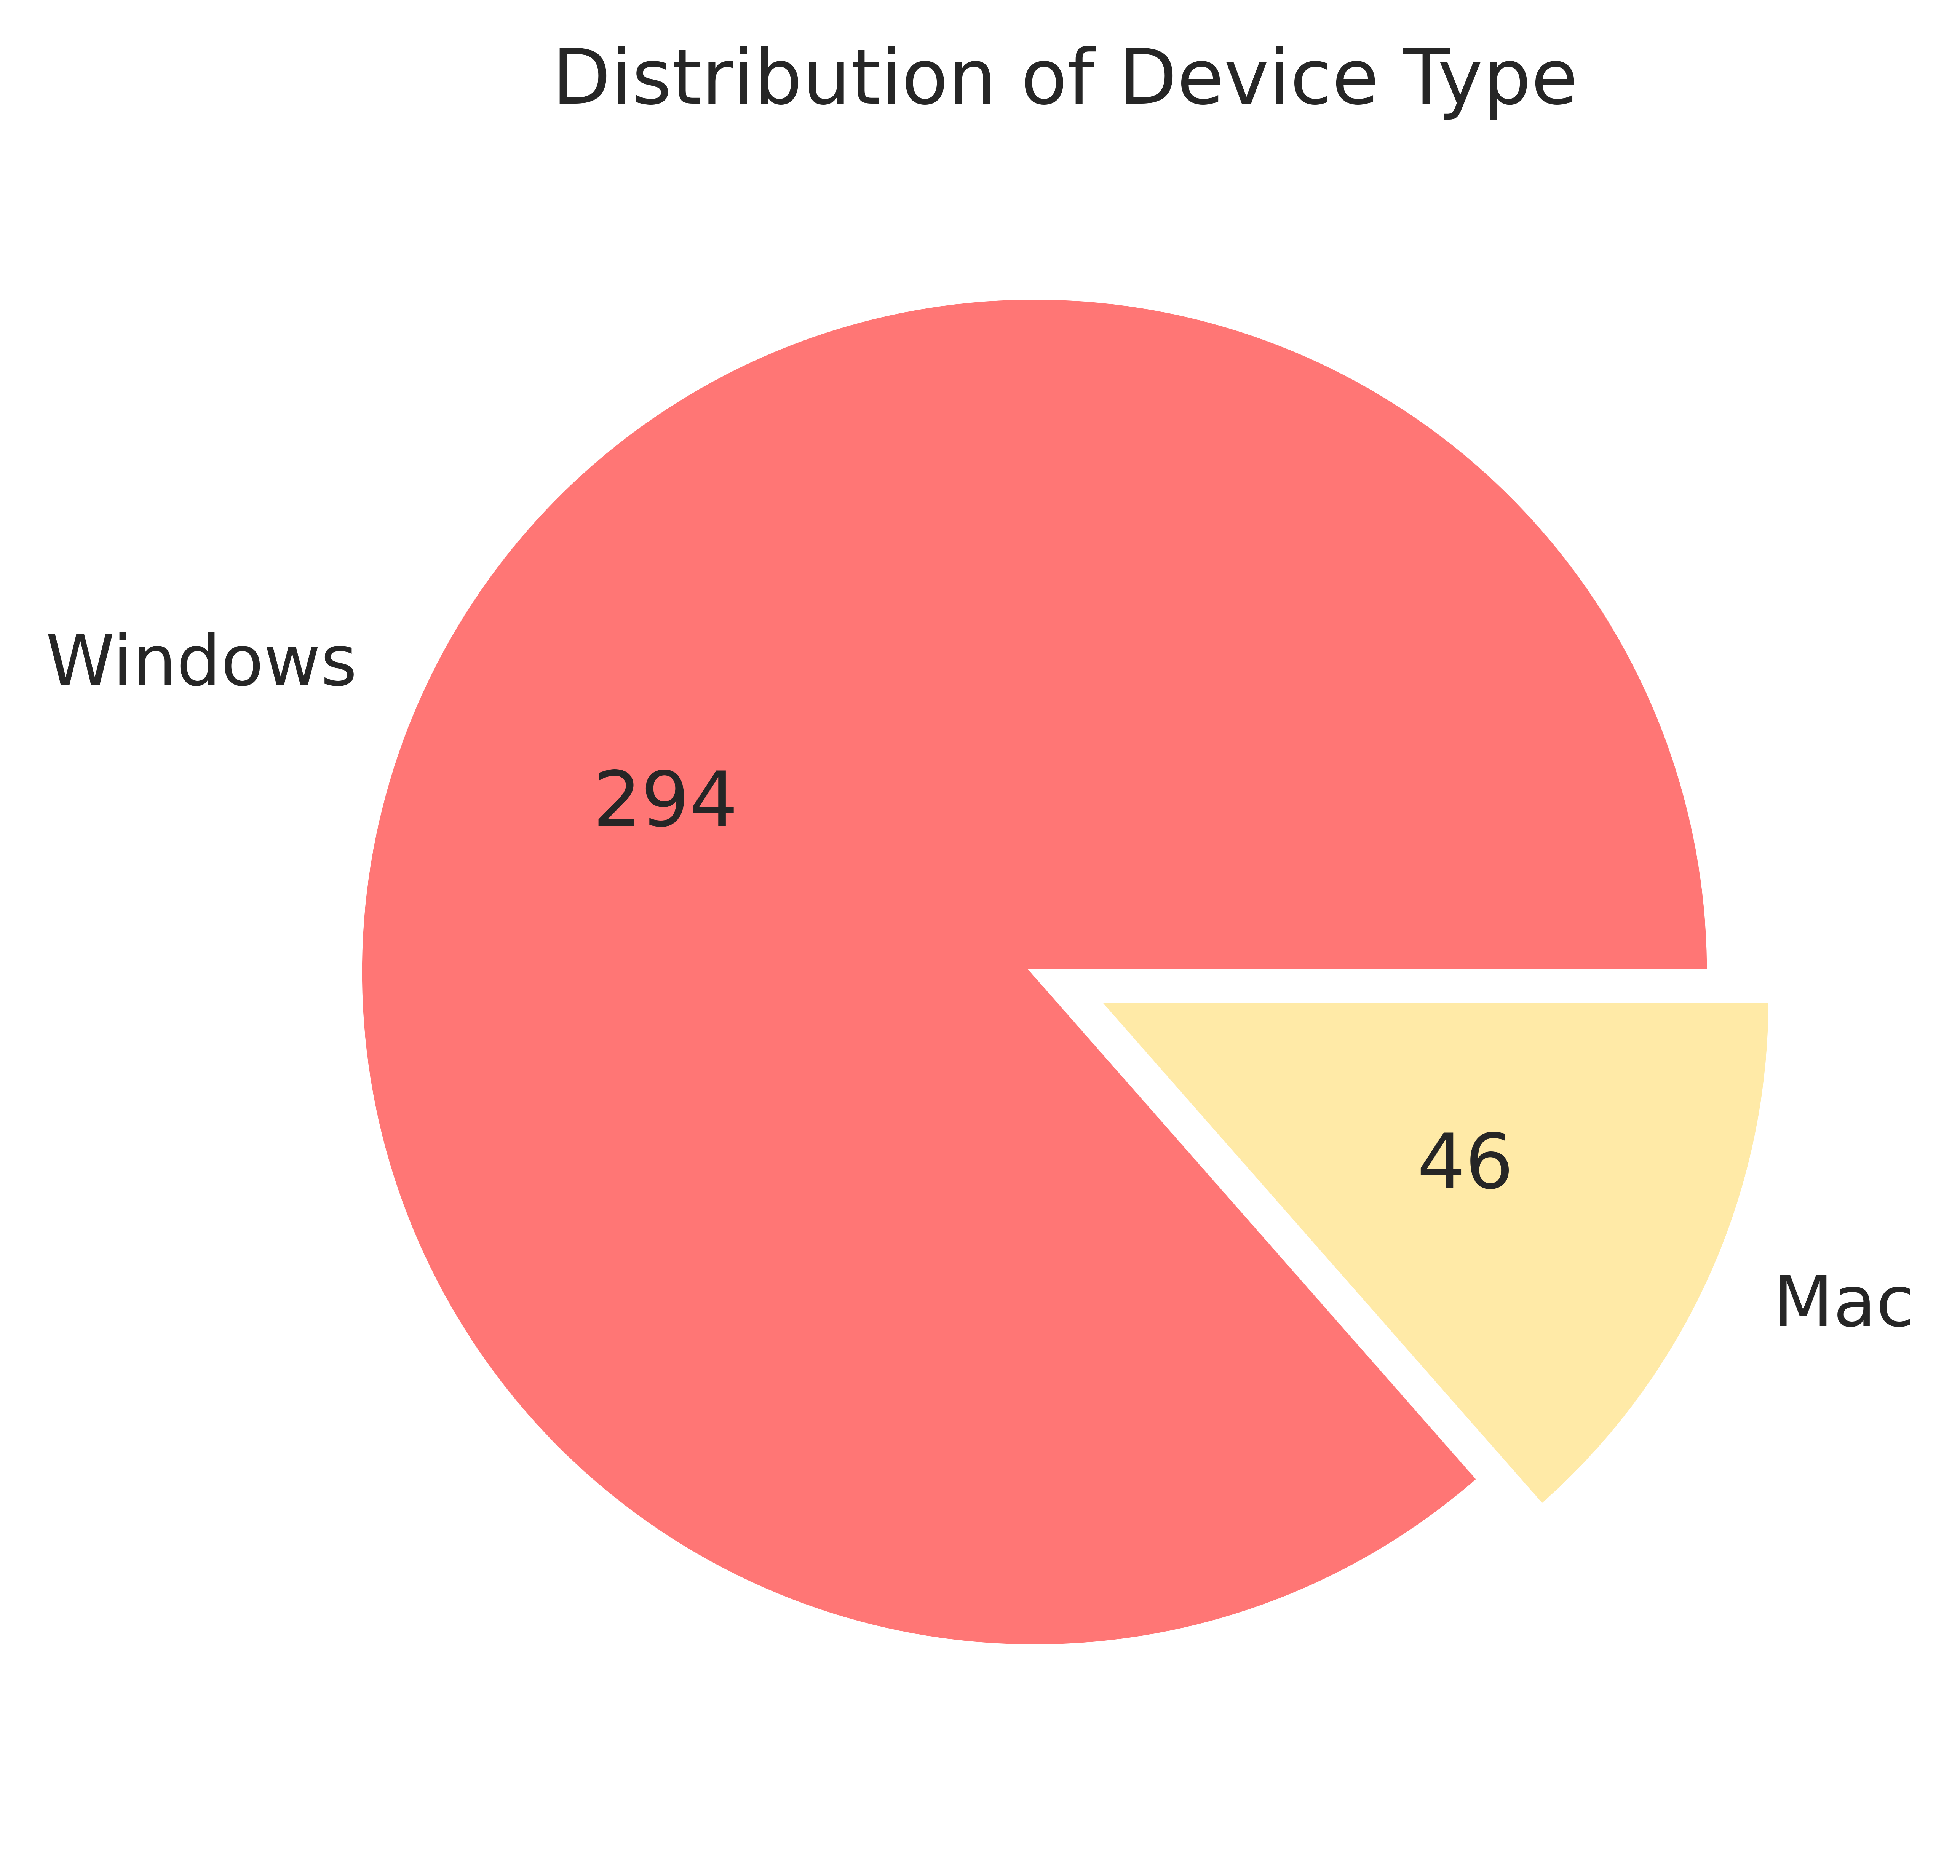

In [ ]:
plt.figure(dpi=1200)
device_counts = final_data['Device_type'].value_counts()
device_counts = device_counts[device_counts.index != 'Desktop']
device_counts = device_counts.rename({'Windows Desktop': 'Windows', 'Mac Desktop': 'Mac'})

labels = [f'{device_type} ({count})' for device_type, count in zip(device_counts.index, device_counts.values)]
explode = [0.05] * len(device_counts)
device_counts.plot.pie(autopct=percent_with_num(counts), colors=["#ff7675", "#ffeaa7", "#81ecec", "#6c5ce7"], explode=explode)
plt.title('Distribution of Device Type')
plt.ylabel('')
plt.show()

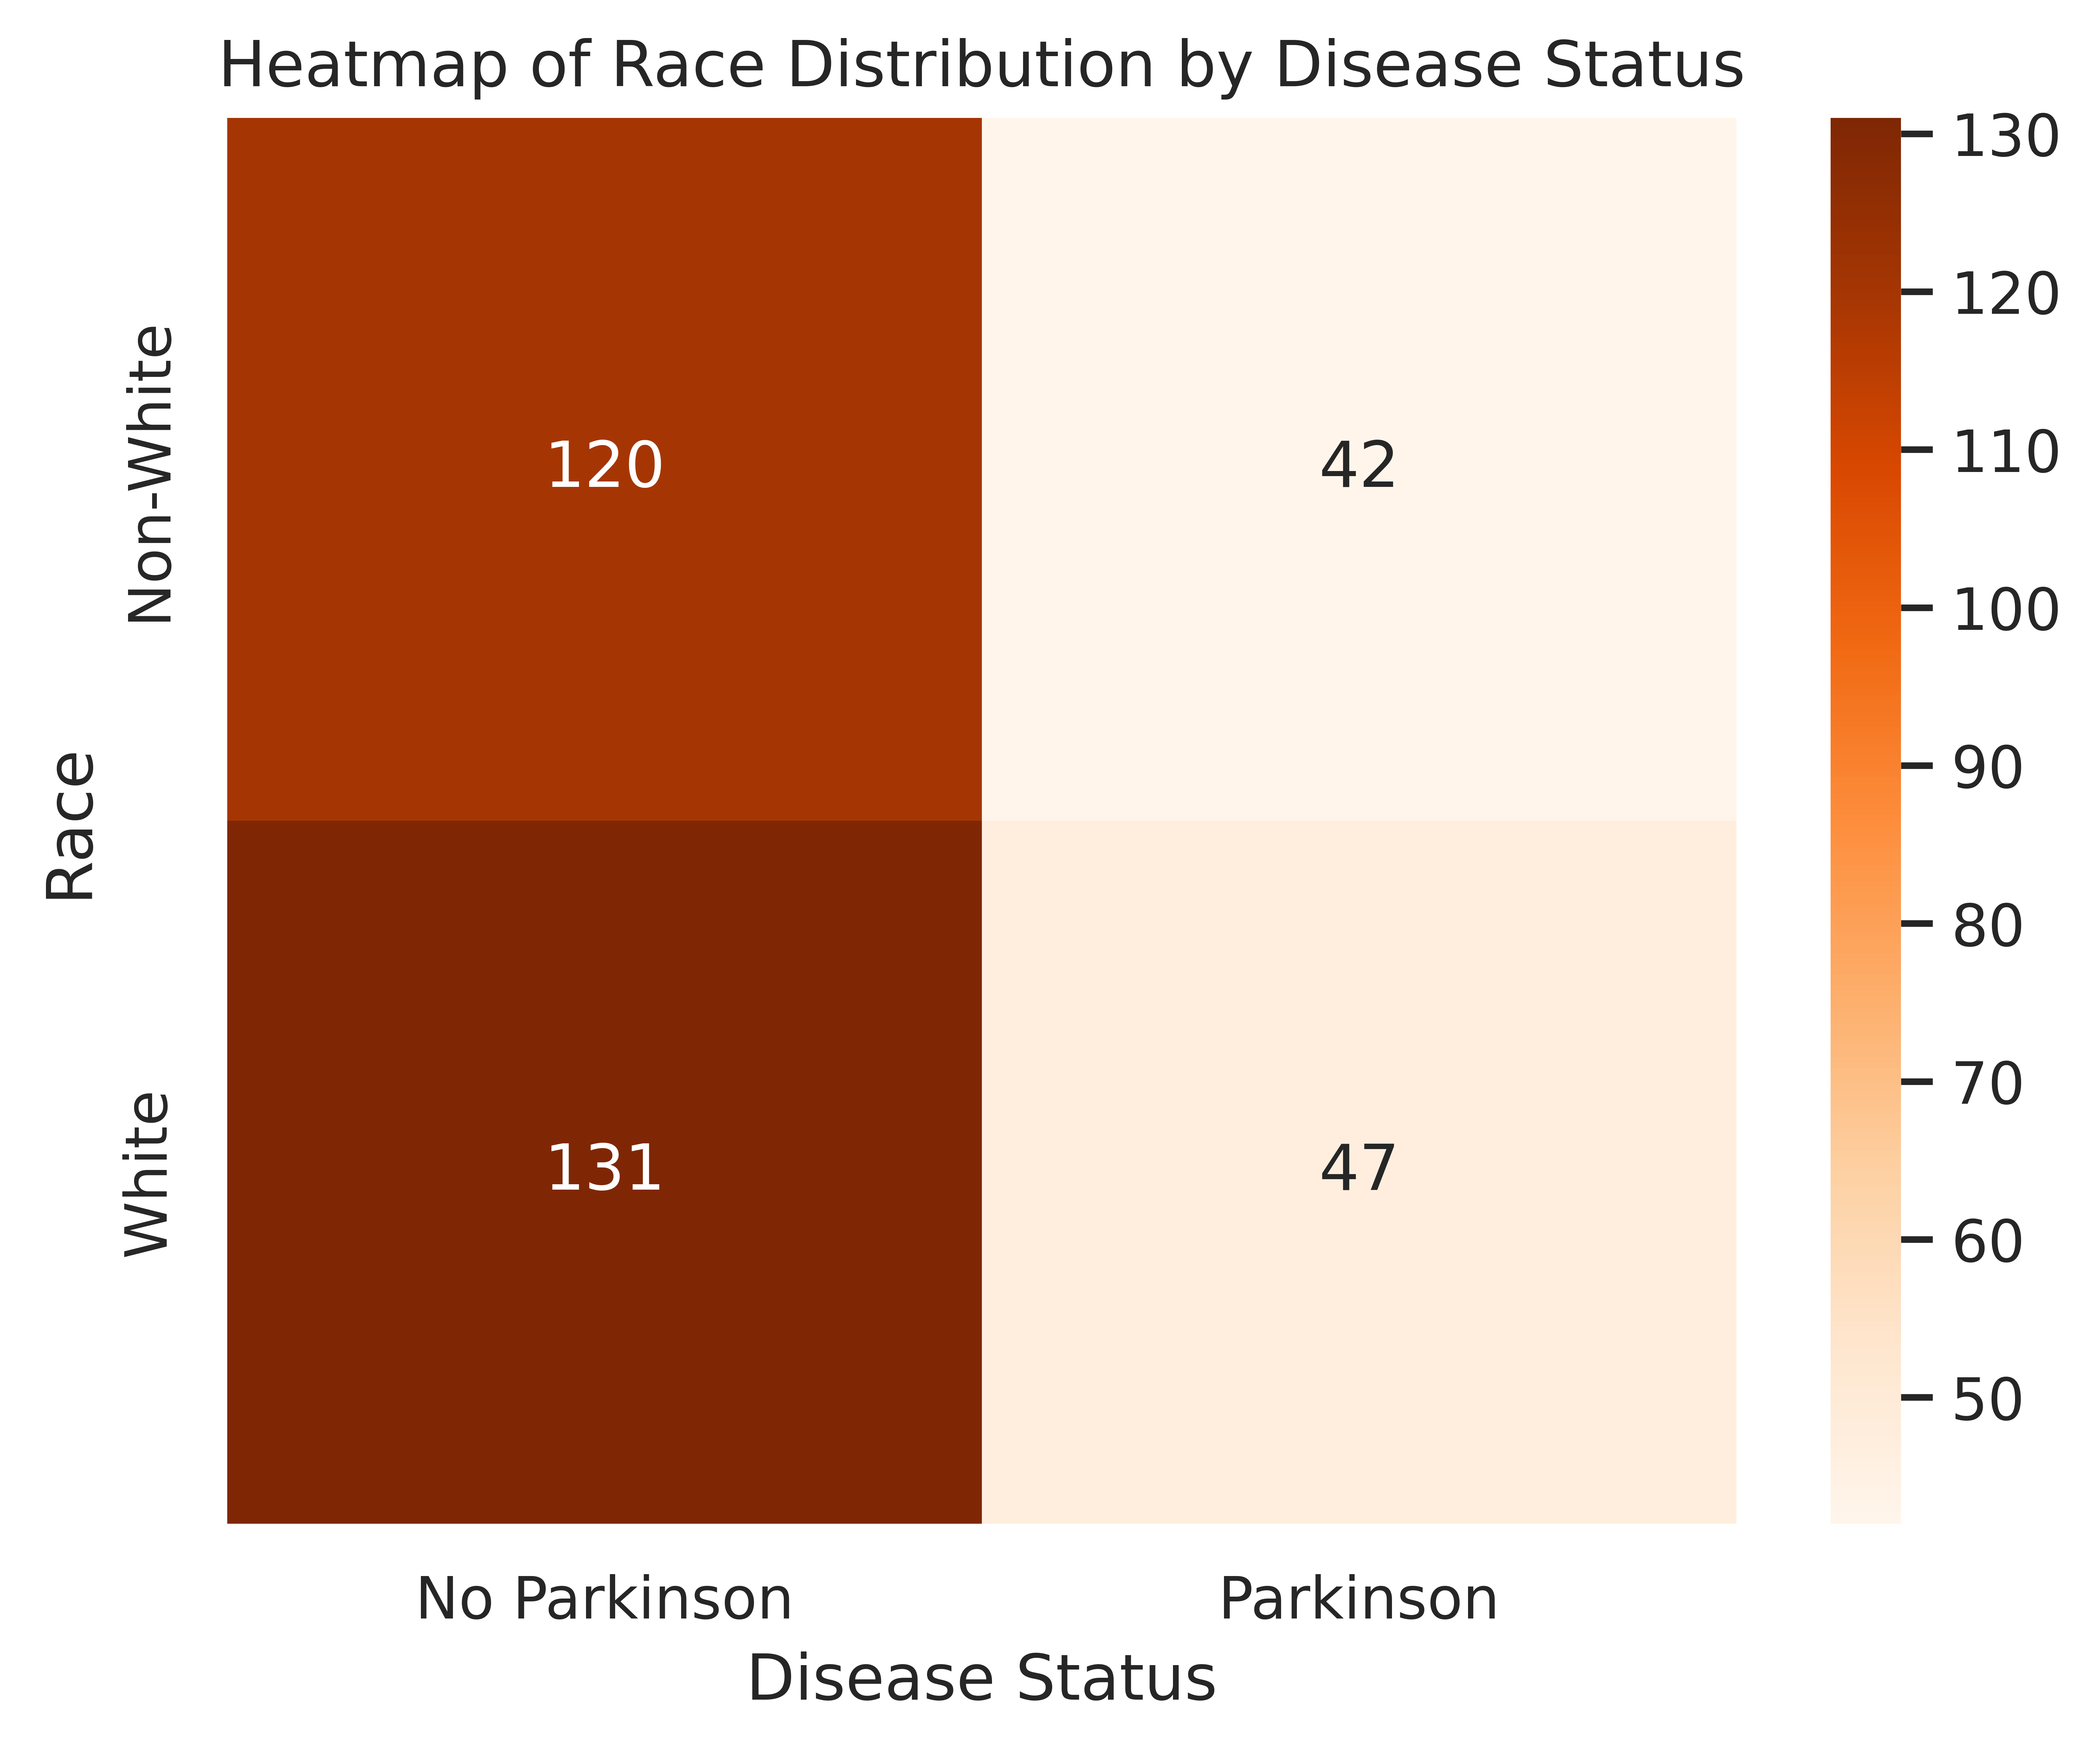

In [ ]:
plt.figure(dpi=1200)
heatmap_data = final_data.pivot_table(index='Race', columns="Parkinson's Disease status", aggfunc='size', fill_value=0)
heatmap_data = heatmap_data.rename(columns={"pd": "Parkinson", "nonpd": "No Parkinson"})

sns.heatmap(heatmap_data, annot=True, cmap='Oranges', fmt='d')
plt.title('Heatmap of Race Distribution by Disease Status')
plt.xlabel('Disease Status')
plt.ylabel('Race')
current_labels = plt.gca().get_yticklabels()
new_labels = ["Non-White" if label.get_text() == "Others" else label.get_text() for label in current_labels]
plt.gca().set_yticklabels(new_labels)
plt.show()


<ipython-input-40-c3c4906a5cfd>:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(new_labels)


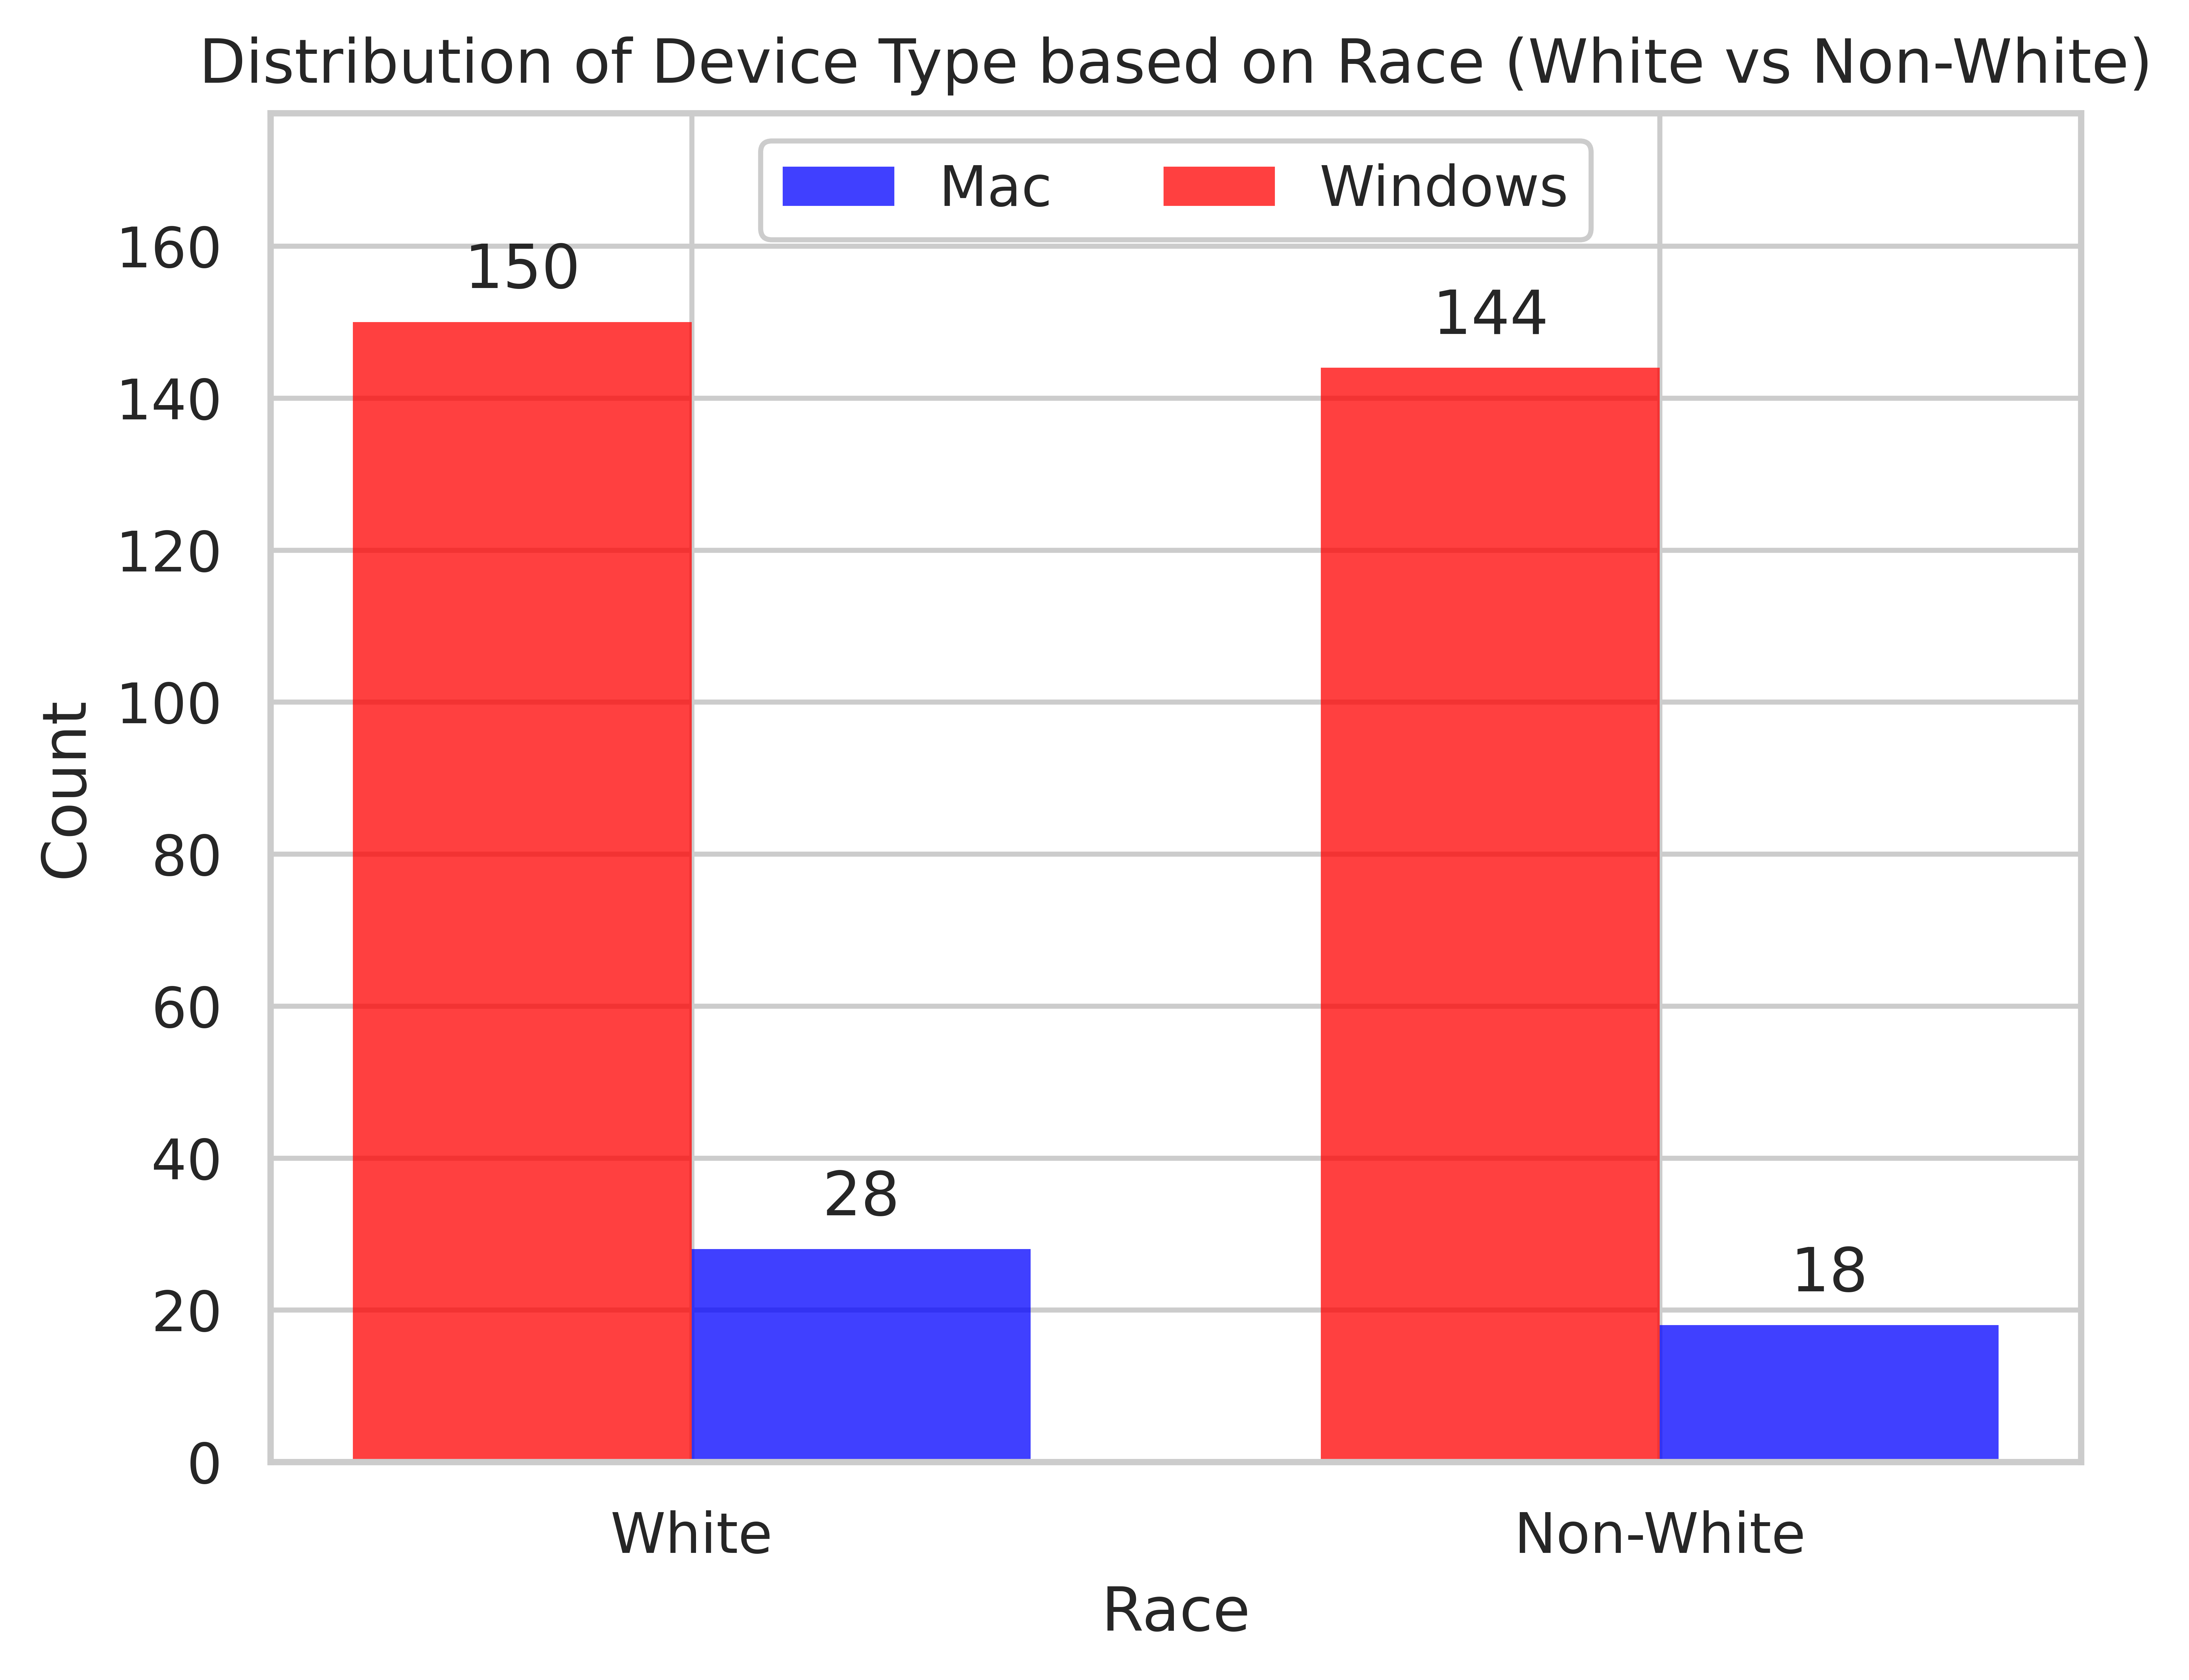

In [ ]:
plt.figure(dpi=1200)
ax = sns.histplot(data=final_data, x='Race', hue="Device_type", shrink=0.7, multiple='dodge', linewidth=0, bins=10, palette=["red", "blue"])
plt.title('Distribution of Device Type based on Race (White vs Non-White)')
plt.legend(["Mac", "Windows"], loc=9, facecolor='white', framealpha=1, ncol=2)
plt.xlabel('Race')
plt.ylabel('Count')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10),
                textcoords='offset points')

x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,y1,y2 + 20))

current_labels = plt.gca().get_xticklabels()
new_labels = ["Non-White" if label.get_text() == "Others" else label.get_text() for label in current_labels]
plt.gca().set_xticklabels(new_labels)

plt.show()

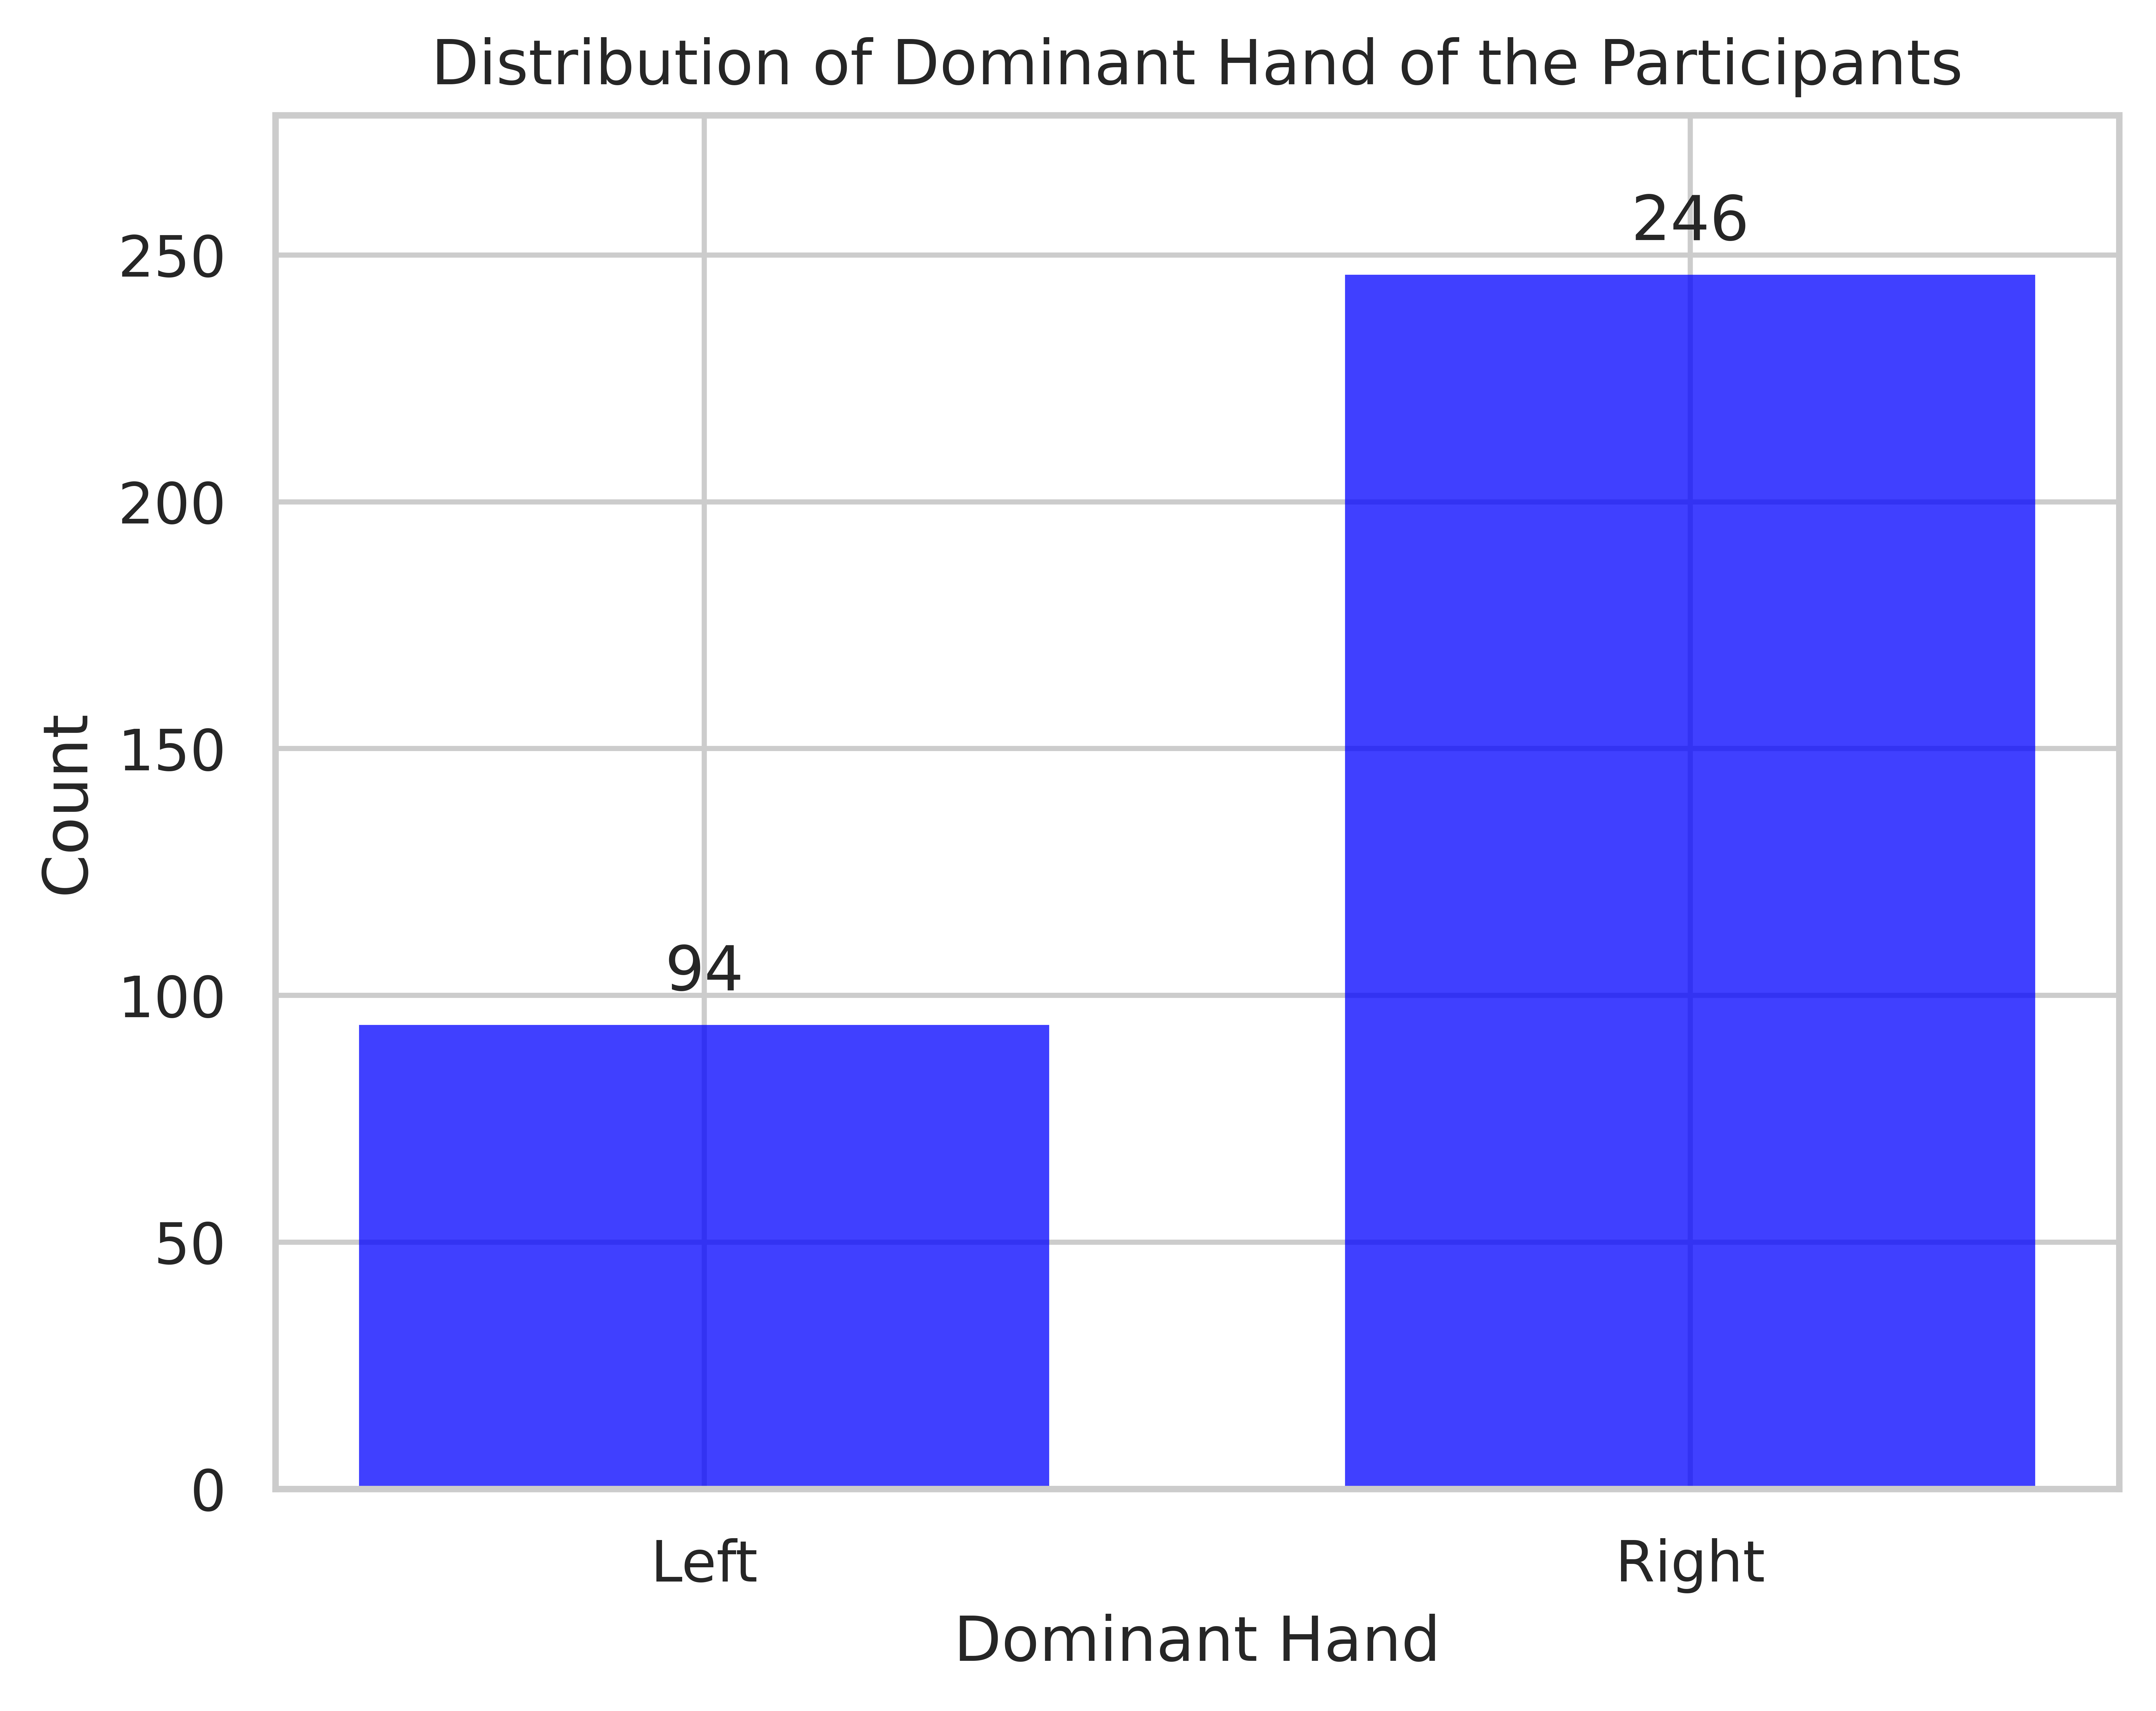

In [ ]:
plt.figure(dpi=1200)
ax = sns.histplot(data=final_data, x='Dominant_hand', shrink=0.7, multiple='dodge', linewidth=0, bins=10, color='blue')
plt.title('Distribution of Dominant Hand of the Participants')
plt.xlabel('Dominant Hand')
plt.ylabel('Count')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10),
                textcoords='offset points')

x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,y1,y2 + 20))

plt.show()

### **Encoding, Balancing and Normalizing**

In [ ]:
final_data = final_data.reset_index()
featureset = final_data.drop("Parkinson's Disease status", axis=1)
label = final_data["Parkinson's Disease status"]

In [ ]:
le = LabelEncoder()
label_encoded = le.fit_transform(label)

In [ ]:
categorical_columns = featureset.select_dtypes(include=['object']).columns
featureset = pd.get_dummies(featureset, columns=categorical_columns, prefix=categorical_columns).astype(float)

In [ ]:
from imblearn.over_sampling import SMOTE, RandomOverSampler
from collections import Counter

smote = SMOTE(random_state=67)

X_res, y_res = smote.fit_resample(featureset, label_encoded)
X_train, y_train = X_res, y_res

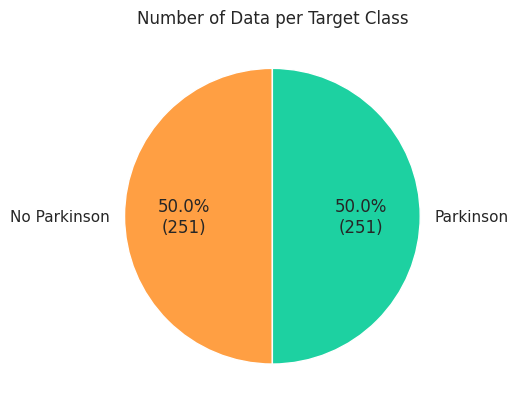

In [ ]:
sns.set()

plt.figure(dpi=1200)
counts = Counter(y_train)
counts = pd.Series(counts).rename(index={1: "Parkinson", 0: "No Parkinson"})
plt.pie(counts, labels=counts.index, autopct=percent_with_num(counts), startangle=90, colors=["#ff9f43", "#1dd1a1"])
plt.title("Number of Data per Target Class")

sns.set_style("whitegrid")
sns.despine()
plt.show()

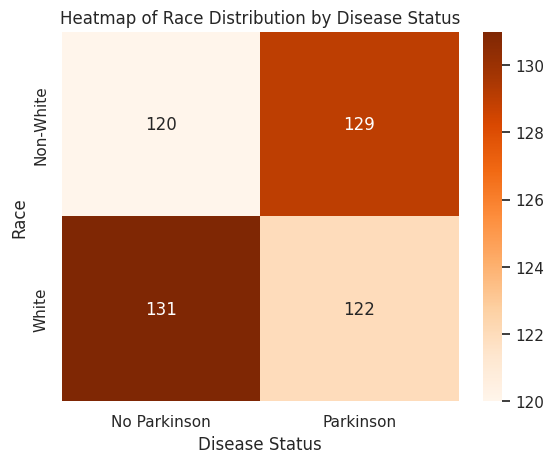

In [ ]:
label = pd.Series(y_train).map({1: "Parkinson", 0: "No Parkinson"})

combined_data = combined_data = X_train.assign(
    Race=np.where(X_train['Race_White'] > 0.5, 'White', 'Others'),
    Label=label
)

heatmap_data = combined_data.pivot_table(index='Race', columns="Label", aggfunc='size', fill_value=0)
sns.heatmap(heatmap_data, annot=True, cmap='Oranges', fmt='d')
plt.title('Heatmap of Race Distribution by Disease Status')
plt.xlabel('Disease Status')
plt.ylabel('Race')
current_labels = plt.gca().get_yticklabels()
new_labels = ["Non-White" if label.get_text() == "Others" else label.get_text() for label in current_labels]
plt.gca().set_yticklabels(new_labels)
plt.show()


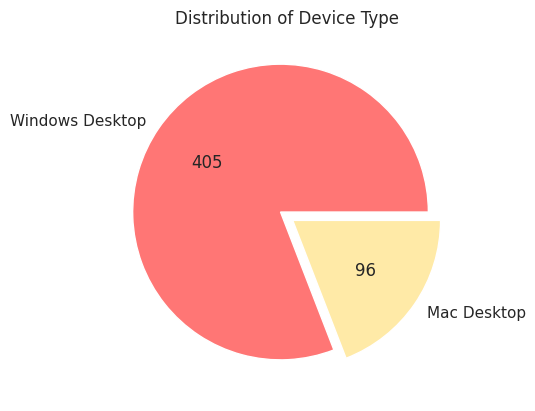

In [ ]:
device_counts = X_train.assign(Device_type=np.where(X_train['Device_type_Mac Desktop'] > 0.5, 'Mac Desktop', 'Windows Desktop'))['Device_type'].value_counts()
labels = [f'{device_type} ({count})' for device_type, count in zip(device_counts.index, device_counts.values)]
explode = [0.05] * len(device_counts)

def percent_with_num(values):
    def my_format(pct):
            total = sum(values)
            val = int(pct*total/100.0)
            return '{v:d}'.format(v=val)
    return my_format

device_counts.plot.pie(autopct=percent_with_num(counts), colors=["#ff7675", "#ffeaa7", "#81ecec", "#6c5ce7"], explode=explode)
plt.title('Distribution of Device Type')
plt.ylabel('')
plt.show()

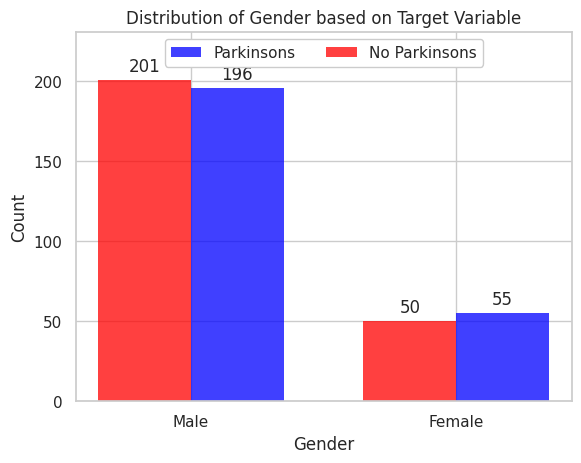

In [ ]:
combined_data = X_train.assign(Gender=np.where(X_train['Gender_Male'] > 0.5, 'Male', 'Female'))
combined_data["Parkinson's Disease status"] = pd.Series(y_train).map({1: "Parkinson", 0: "No Parkinson"})
ax = sns.histplot(data=combined_data, x='Gender', hue="Parkinson's Disease status", shrink=0.7, multiple='dodge', linewidth=0, bins=10, palette=["red", "blue"])
plt.title('Distribution of Gender based on Target Variable')
plt.legend(["Parkinsons", "No Parkinsons"], loc=9, facecolor='white', framealpha=1, ncol=2)
plt.xlabel('Gender')
plt.ylabel('Count')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10),
                textcoords='offset points')

x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,y1,y2 + 20))
plt.show()

<ipython-input-32-75e78bc3f3a6>:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(new_labels)


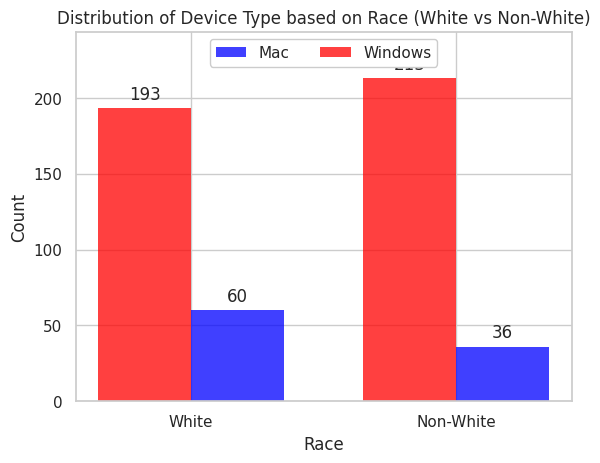

In [ ]:
combined_data = X_train.assign(Race=np.where(X_train['Race_White'] > 0.5, 'White', 'Others'))
combined_data['Device_type'] = X_train.assign(Device_type=np.where(X_train['Device_type_Windows Desktop'] > 0.5, 'Windows', 'Mac'))['Device_type']
combined_data["Parkinson's Disease status"] = pd.Series(y_train).map({1: "Parkinson", 0: "No Parkinson"})
ax = sns.histplot(data=combined_data, x='Race', hue="Device_type", shrink=0.7, multiple='dodge', linewidth=0, bins=10, palette=["red", "blue"])
plt.title('Distribution of Device Type based on Race (White vs Non-White)')
plt.legend(["Mac", "Windows"], loc=9, facecolor='white', framealpha=1, ncol=2)
plt.xlabel('Race')
plt.ylabel('Count')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10),
                textcoords='offset points')

x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,y1,y2 + 20))

current_labels = plt.gca().get_xticklabels()
new_labels = ["Non-White" if label.get_text() == "Others" else label.get_text() for label in current_labels]
plt.gca().set_xticklabels(new_labels)

plt.show()

In [ ]:
numerical_columns = X_train.select_dtypes(include=['int64', 'float64']).columns

numerical_columns

scaler = MinMaxScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
pd.DataFrame(X_train, index = X_train.index, columns= X_train.columns)

index       Age  M_deviation     A_tcl   A_tslww     P_isl  N_tislnt  \
0    0.000000  0.593220     0.183579  0.016393  0.022255  1.000000  0.016393   
1    0.007692  0.644068     0.194368  0.008197  0.012353  1.000000  0.008197   
2    0.015385  0.661017     0.184607  0.016393  0.022255  1.000000  0.016393   
3    0.019231  0.576271     0.208239  0.008197  0.012353  1.000000  0.008197   
4    0.034615  0.661017     0.192482  0.024590  0.044455  1.000000  0.024590   
..        ...       ...          ...       ...       ...       ...       ...   
497  0.715580  0.689039     0.219051  0.040984  0.032720  0.922065  0.037304   
498  0.676875  0.433328     0.177261  0.041840  0.043691  0.813422  0.034499   
499  0.788342  0.738339     0.261616  0.059494  0.052159  0.784318  0.042457   
500  0.849581  0.763032     0.222362  0.049180  0.044922  0.851190  0.040984   
501  0.600197  0.557234     0.243911  0.062846  0.092694  0.651032  0.038492   

        A_tsw     A_tww    P_ptsw  ...  Platform_protected  \
0    0.028436  0.033584  0.857143  ...            0.000000   
1    0.028436  0.033584  0.714286  ...            0.000000   
2    0.028436  0.033584  0.571429  ...            0.000000   
3    0.037915  0.044579  0.555556  ...            0.000000   
4    0.085308  0.131988  0.894737  ...            0.000000   
..        ...       ...       ...  ...                 ...   
497  0.075639  0.053373  0.655500  ...            0.448907   
498  0.087573  0.091196  0.613947  ...            0.552213   
499  0.080725  0.066469  0.407548  ...            0.000000   
500  0.056872  0.049102  0.384615  ...            0.890990   
501  0.055158  0.075454  0.603310  ...            0.000000   

     Preferred_hand_protected  Gender_Female  Gender_Male  Race_Others  \
0                    0.000000       0.000000     1.000000     0.000000   
1                    0.000000       0.000000     1.000000     0.000000   
2                    0.000000       0.000000     1.000000     0.000000   
3                    1.000000       0.000000     1.000000     0.000000   
4                    1.000000       0.000000     1.000000     0.000000   
..                        ...            ...          ...          ...   
497                  0.551093       0.000000     1.000000     0.551093   
498                  1.000000       0.000000     1.000000     0.447787   
499                  1.000000       0.179752     0.820248     0.820248   
500                  1.000000       0.000000     1.000000     1.000000   
501                  0.123200       0.123200     0.876800     0.000000   

     Race_White  Dominant_hand_Left  Dominant_hand_Right  \
0      1.000000            1.000000             0.000000   
1      1.000000            1.000000             0.000000   
2      1.000000            1.000000             0.000000   
3      1.000000            0.000000             1.000000   
4      1.000000            0.000000             1.000000   
..          ...                 ...                  ...   
497    0.448907            0.448907             0.551093   
498    0.552213            0.000000             1.000000   
499    0.179752            0.000000             1.000000   
500    0.000000            0.000000             1.000000   
501    1.000000            0.876800             0.123200   

     Device_type_Mac Desktop  Device_type_Windows Desktop  
0                   0.000000                     1.000000  
1                   0.000000                     1.000000  
2                   0.000000                     1.000000  
3                   0.000000                     1.000000  
4                   0.000000                     1.000000  
..                       ...                          ...  
497                 0.448907                     0.551093  
498                 0.552213                     0.447787  
499                 0.000000                     1.000000  
500                 0.890990                     0.109010  
501                 0.000000    

## **Custom Scorer Function**

In [ ]:
import scipy.stats as stats


def calculate_confidence_interval(data, confidence=0.95):
  if np.std(data, ddof=1) == 0:
    return (np.mean(data), np.mean(data))
  return stats.t.interval(confidence=confidence, df=len(data)-1, loc=np.mean(data), scale=stats.sem(data))

In [ ]:
def calculate_metrics_from_cm(cm):
  TP = cm['TP']
  FP = cm['FP']
  TN = cm['TN']
  FN = cm['FN']

  precision = TP / (TP + FP) if (TP + FP) != 0 else 0
  recall = TP / (TP + FN) if (TP + FN) != 0 else 0 # Sensitivity is same as recall
  specificity = TN / (TN + FP) if (TN + FP) != 0 else 0

  if precision + recall == 0:
        return 0, recall, specificity, precision

  f1_score = (2 * precision * recall) / (precision + recall)

  return f1_score, recall, specificity, precision

In [ ]:
def calculate_eq_odds_diff(unpriv_cm, priv_cm):
  unpriv_TP = unpriv_cm['TP']
  unpriv_FP = unpriv_cm['FP']
  unpriv_TN = unpriv_cm['TN']
  unpriv_FN = unpriv_cm['FN']

  priv_TP = priv_cm['TP']
  priv_FP = priv_cm['FP']
  priv_TN = priv_cm['TN']
  priv_FN = priv_cm['FN']

  unpriv_tpr = unpriv_TP / (unpriv_TP + unpriv_FN) if (unpriv_TP + unpriv_FN) != 0 else 0
  unpriv_fpr = unpriv_FP / (unpriv_FP + unpriv_TN) if (unpriv_FP + unpriv_TN) != 0 else 0

  priv_tpr = priv_TP / (priv_TP + priv_FN) if (priv_TP + priv_FN) != 0 else 0
  priv_fpr = priv_FP / (priv_FP + priv_TN) if (priv_FP + priv_TN) != 0 else 0

  diff_tpr = abs(unpriv_tpr - priv_tpr)
  diff_fpr = abs(unpriv_fpr - priv_fpr)

  return max(diff_tpr, diff_fpr)

In [ ]:
from scipy import stats


def calculate_p_value(unprivileged, privileged):
  t_statistic, p_value = stats.ttest_ind(unprivileged, privileged)
  return p_value

In [ ]:
from sklearn.metrics import roc_auc_score


def calculate_auc(auc_test_set, clf, protected_attribute):
  auc_score = {}
  privileged_group = auc_test_set[auc_test_set[protected_attribute] == 1]
  unprivileged_group = auc_test_set[auc_test_set[protected_attribute] == 0]

  if len(privileged_group['PD_status'].unique()) == 2:
      privileged_group_auc = roc_auc_score(privileged_group['PD_status'], privileged_group['prediction'])
  else:
      privileged_group_auc = np.nan

  if len(unprivileged_group['PD_status'].unique()) == 2:
      unprivileged_group_auc = roc_auc_score(unprivileged_group['PD_status'], unprivileged_group['prediction'])
  else:
      unprivileged_group_auc = np.nan

  return privileged_group_auc, unprivileged_group_auc

In [ ]:
from aif360.metrics import ClassificationMetric
from collections import defaultdict
import gc


def bootstrap_scorer(clf, X, y):
  unprivileged_groups = [{'Sex_protected': 0}, {'Ethnicity_protected': 0}, {'Platform_protected': 0}, {'Preferred_hand_protected': 0}]
  privileged_groups= [{'Sex_protected': 1}, {'Ethnicity_protected': 1}, {'Platform_protected': 1}, {'Preferred_hand_protected': 1}]
  f1_scores = []
  sensitivity_scores = []
  specificity_scores = []
  bias_metrics = None
  result = {}
  metrics = defaultdict(list)
  half_size = len(X) // 2



  for _ in range(100):
    X_resampled, y_resampled = resample(X, y, replace=True)
    y_pred = clf.predict(X_resampled)

    f1_scores.append(f1_score(y_resampled, y_pred))
    sensitivity_scores.append(recall_score(y_resampled, y_pred, pos_label=1))
    specificity_scores.append(recall_score(y_resampled, y_pred, pos_label=0))

    for unprivileged, privileged in zip(unprivileged_groups, privileged_groups):
      group = list(unprivileged.keys())[0]
      test_group = X.copy()
      test_group['PD_status'] = y

      unprivileged_group = test_group[test_group[group] == 0]
      privileged_group = test_group[test_group[group] == 1]

      unprivileged_resampled = resample(unprivileged_group, replace=True, n_samples=half_size)
      privileged_resampled = resample(privileged_group, replace=True, n_samples=half_size)
      test_resampled = pd.concat([unprivileged_resampled, privileged_resampled])
      y_test_resampled = test_resampled['PD_status']
      X_test_resampled = test_resampled.drop('PD_status', axis=1)

      y_pred = clf.predict(X_test_resampled)
      pred_proba = clf.predict_proba(X_test_resampled)[:, 1]
      X_test_resampled['PD_status'] = y_test_resampled


      test_set_aif = BinaryLabelDataset(df=X_test_resampled,
                                  favorable_label=1,
                                  unfavorable_label=0,
                                  label_names=["PD_status"],
                                  protected_attribute_names=['Sex_protected', 'Ethnicity_protected', 'Platform_protected', 'Preferred_hand_protected'])

      test_pred = test_set_aif.copy()
      test_pred.labels = y_pred.reshape(-1, 1)

      X_test_resampled['prediction'] = pred_proba
      privileved_auc_score, unprivileged_auc_score = calculate_auc(X_test_resampled, clf, group)

      bias_metrics = ClassificationMetric(test_set_aif, test_pred,
                          unprivileged_groups = [unprivileged],
                          privileged_groups = [privileged])

      key = list(unprivileged.keys())[0]

      unprivileged_cm = bias_metrics.binary_confusion_matrix(privileged=False)
      privileged_cm = bias_metrics.binary_confusion_matrix(privileged=True)
      di = bias_metrics.disparate_impact()
      eq_odds = calculate_eq_odds_diff(unprivileged_cm, privileged_cm)

      unprivileged_f1, unprivileged_sensitiviy, unprivileged_specificity, unprivileged_precision = calculate_metrics_from_cm(unprivileged_cm)
      privileged_f1, privileged_sensitiviy, privileged_specificity, privileged_precision = calculate_metrics_from_cm(privileged_cm)

      eq_opp = unprivileged_sensitiviy/privileged_sensitiviy if privileged_sensitiviy != 0 else 0

      metrics[f"unprivileged_{key}_f1"].append(unprivileged_f1)
      metrics[f"unprivileged_{key}_sensitivity"].append(unprivileged_sensitiviy)
      metrics[f"unprivileged_{key}_specificity"].append(unprivileged_specificity)
      metrics[f"unprivileged_{key}_precision"].append(unprivileged_precision)
      metrics[f"unprivileged_{key}_auc"].append(unprivileged_auc_score)
      metrics[f"privileged_{key}_f1"].append(privileged_f1)
      metrics[f"privileged_{key}_sensitivity"].append(privileged_sensitiviy)
      metrics[f"privileged_{key}_specificity"].append(privileged_specificity)
      metrics[f"privileged_{key}_precision"].append(privileged_precision)
      metrics[f"privileged_{key}_auc"].append(privileved_auc_score)


      metrics[f"{key}_disparate_impact"].append(di)
      metrics[f"{key}_equalized_odds_difference"].append(eq_odds)
      metrics[f"{key}_equal_opportunity"].append(eq_opp)

    del X_resampled, y_resampled, test_group, unprivileged_group,
    privileged_group, unprivileged_resampled, privileged_resampled,
    test_resampled, y_test_resampled, X_test_resampled, y_pred, test_set_aif,
    test_pred, bias_metrics

    gc.collect()

  for unprivileged, privileged in zip(unprivileged_groups, privileged_groups):
      key = list(unprivileged.keys())[0]
      result[f"{key}_f1_p"]= calculate_p_value(np.array(metrics[f"unprivileged_{key}_f1"]), np.array(metrics[f"privileged_{key}_f1"]))

  f1_score_lower, f1_score_upper = calculate_confidence_interval(np.array(f1_scores))
  sensitivity_lower, sensitivity_upper  = calculate_confidence_interval(np.array(sensitivity_scores))
  specificity_lower, specificity_upper = calculate_confidence_interval(np.array(specificity_scores))
  f1_std = np.std(f1_scores)
  sensitivity_std = np.std(sensitivity_scores)
  specificity_std = np.std(specificity_scores)


  for key, value in metrics.items():
    result[f"{key}_mean"] = np.mean(value)
    result[f"{key}_std"] = np.std(value)
    result[f"{key}_lower"], result[f"{key}_upper"] = calculate_confidence_interval(np.array(value))

  return_values = {'f1_score_mean': np.mean(f1_scores), 'f1_score_upper': f1_score_upper, 'f1_score_lower': f1_score_lower,
                   'sensitivity_mean': np.mean(sensitivity_scores), 'sensitivity_upper': sensitivity_upper, 'sensitivity_lower': sensitivity_lower,
                   'specificity_mean': np.mean(specificity_scores), 'specificity_upper': specificity_upper, 'specificity_lower': specificity_lower,
                   'f1_score_std': f1_std, 'sensitivity_std': sensitivity_std, 'specificity_std': specificity_std}

  return_values.update(result)

  return return_values

pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


In [ ]:
from IPython.display import Markdown


def print_cv_results_std(result, title):
  display(Markdown(f"# **{title} (Mean of 5-fold Cross Validation with 1000 Bootstrap Sampling at Each Fold)**"))
  display(Markdown("## **Model Performance**"))
  print(f"F1 Score: {result['test_f1_score_mean'].mean():.2f} ({np.std(result['test_f1_score_mean']):.2f})")
  print(f"Sensitivity: {result['test_sensitivity_mean'].mean():.2f} ({np.std(result['test_sensitivity_mean']):.2f})")
  print(f"Specificity: {result['test_specificity_mean'].mean():.2f} ({np.std(result['test_specificity_mean']):.2f})")


  display(Markdown("## **Fairness Metrics**"))

  p_value = calculate_p_value(result['test_unprivileged_Sex_protected_f1_mean'], result['test_privileged_Sex_protected_f1_mean'])
  p_decision = "Significant" if p_value < 0.05 else "Not Significant"
  display(Markdown("###**Gender**"))
  print(f"Disparate Impact: {np.mean(result['test_Sex_protected_disparate_impact_mean']):.2f} ({np.std(result['test_Sex_protected_disparate_impact_mean']):.2f})")
  print(f"Equal Opportunity: {np.mean(result['test_Sex_protected_equal_opportunity_mean']):.2f} ({np.std(result['test_Sex_protected_equal_opportunity_mean']):.2f})")
  print(f"Equalied Odds Difference: {np.mean(result['test_Sex_protected_equalized_odds_difference_mean']):.2f} ({np.std(result['test_Sex_protected_equalized_odds_difference_mean']):.2f})")
  print(f"Significant Difference: {p_decision}")


  display(Markdown("**Female**"))
  print(f"F1 Score: {result['test_unprivileged_Sex_protected_f1_mean'].mean():.2f} ({np.std(result['test_unprivileged_Sex_protected_f1_mean']):.2f})")
  print(f"Sensitivity: {result['test_unprivileged_Sex_protected_sensitivity_mean'].mean():.2f} ({np.std(result['test_unprivileged_Sex_protected_sensitivity_mean']):.2f})")
  print(f"Specificity: {result['test_unprivileged_Sex_protected_specificity_mean'].mean():.2f} ({np.std(result['test_unprivileged_Sex_protected_specificity_mean']):.2f})")
  print(f"Precision: {result['test_unprivileged_Sex_protected_precision_mean'].mean():.2f} ({np.std(result['test_unprivileged_Sex_protected_precision_mean']):.2f})")
  print(f"AUC: {np.nanmean(result['test_unprivileged_Sex_protected_auc_mean']):.2f} ({np.nanstd(result['test_unprivileged_Sex_protected_auc_mean']):.2f})")
  display(Markdown("**Male**"))
  print(f"F1 Score: {result['test_privileged_Sex_protected_f1_mean'].mean():.2f} ({np.std(result['test_privileged_Sex_protected_f1_mean']):.2f})")
  print(f"Sensitivity: {result['test_privileged_Sex_protected_sensitivity_mean'].mean():.2f} ({np.std(result['test_privileged_Sex_protected_sensitivity_mean']):.2f})")
  print(f"Specificity: {result['test_privileged_Sex_protected_specificity_mean'].mean():.2f} ({np.std(result['test_privileged_Sex_protected_specificity_mean']):.2f})")
  print(f"Precision: {result['test_privileged_Sex_protected_precision_mean'].mean():.2f} ({np.std(result['test_privileged_Sex_protected_precision_mean']):.2f})")
  print(f"AUC: {np.nanmean(result['test_privileged_Sex_protected_auc_mean']):.2f} ({np.nanstd(result['test_privileged_Sex_protected_auc_mean']):.2f})")


  print("")

  p_value = calculate_p_value(result['test_unprivileged_Ethnicity_protected_f1_mean'], result['test_privileged_Ethnicity_protected_f1_mean'])
  p_decision = "Significant" if p_value < 0.05 else "Not Significant"

  display(Markdown("###**Race**"))
  print(f"Disparate Impact: {np.mean(result['test_Ethnicity_protected_disparate_impact_mean']):.2f} ({np.std(result['test_Ethnicity_protected_disparate_impact_mean']):.2f})")
  print(f"Equal Opportunity: {np.mean(result['test_Ethnicity_protected_equal_opportunity_mean']):.2f} ({np.std(result['test_Ethnicity_protected_equal_opportunity_mean']):.2f})")
  print(f"Equalied Odds Difference: {np.mean(result['test_Ethnicity_protected_equalized_odds_difference_mean']):.2f} ({np.std(result['test_Ethnicity_protected_equalized_odds_difference_mean']):.2f})")

  print(f"Significant Difference: {p_decision}")

  display(Markdown("**Non-White**"))
  print(f"F1 Score: {result['test_unprivileged_Ethnicity_protected_f1_mean'].mean():.2f} ({np.std(result['test_unprivileged_Ethnicity_protected_f1_mean']):.2f})")
  print(f"Sensitivity: {result['test_unprivileged_Ethnicity_protected_sensitivity_mean'].mean():.2f} ({np.std(result['test_unprivileged_Ethnicity_protected_sensitivity_mean']):.2f})")
  print(f"Specificity: {result['test_unprivileged_Ethnicity_protected_specificity_mean'].mean():.2f} ({np.std(result['test_unprivileged_Ethnicity_protected_specificity_mean']):.2f})")
  print(f"Precision: {result['test_unprivileged_Ethnicity_protected_precision_mean'].mean():.2f} ({np.std(result['test_unprivileged_Ethnicity_protected_precision_mean']):.2f})")
  print(f"AUC: {np.nanmean(result['test_unprivileged_Ethnicity_protected_auc_mean']):.2f} ({np.nanstd(result['test_unprivileged_Ethnicity_protected_auc_mean']):.2f})")


  display(Markdown("**White**"))
  print(f"F1 Score: {result['test_privileged_Ethnicity_protected_f1_mean'].mean():.2f} ({np.std(result['test_privileged_Ethnicity_protected_f1_mean']):.2f})")
  print(f"Sensitivity: {result['test_privileged_Ethnicity_protected_sensitivity_mean'].mean():.2f} ({np.std(result['test_privileged_Ethnicity_protected_sensitivity_mean']):.2f})")
  print(f"Specificity: {result['test_privileged_Ethnicity_protected_specificity_mean'].mean():.2f} ({np.std(result['test_privileged_Ethnicity_protected_specificity_mean']):.2f})")
  print(f"Precision: {result['test_privileged_Ethnicity_protected_precision_mean'].mean():.2f} ({np.std(result['test_privileged_Ethnicity_protected_precision_mean']):.2f})")
  print(f"AUC: {np.nanmean(result['test_privileged_Ethnicity_protected_auc_mean']):.2f} ({np.nanstd(result['test_privileged_Ethnicity_protected_auc_mean']):.2f})")


  print("")
  p_value = calculate_p_value(result['test_unprivileged_Platform_protected_f1_mean'], result['test_privileged_Platform_protected_f1_mean'])
  p_decision = "Significant" if p_value < 0.05 else "Not Significant"


  display(Markdown("###**Device**"))
  print(f"Disparate Impact: {np.mean(result['test_Platform_protected_disparate_impact_mean']):.2f} ({np.std(result['test_Platform_protected_disparate_impact_mean']):.2f})")
  print(f"Equal Opportunity: {np.mean(result['test_Platform_protected_equal_opportunity_mean']):.2f} ({np.std(result['test_Platform_protected_equal_opportunity_mean']):.2f})")
  print(f"Equalied Odds Difference: {np.mean(result['test_Platform_protected_equalized_odds_difference_mean']):.2f} ({np.std(result['test_Platform_protected_equalized_odds_difference_mean']):.2f})")
  print(f"Significant Difference: {p_decision}")

  display(Markdown("**Windows**"))
  print(f"F1 Score: {result['test_unprivileged_Platform_protected_f1_mean'].mean():.2f} ({np.std(result['test_unprivileged_Platform_protected_f1_mean']):.2f})")
  print(f"Sensitivity: {result['test_unprivileged_Platform_protected_sensitivity_mean'].mean():.2f} ({np.std(result['test_unprivileged_Platform_protected_sensitivity_mean']):.2f})")
  print(f"Specificity: {result['test_unprivileged_Platform_protected_specificity_mean'].mean():.2f} ({np.std(result['test_unprivileged_Platform_protected_specificity_mean']):.2f})")
  print(f"Precision: {result['test_unprivileged_Platform_protected_precision_mean'].mean():.2f} ({np.std(result['test_unprivileged_Platform_protected_precision_mean']):.2f})")
  print(f"AUC: {np.nanmean(result['test_unprivileged_Platform_protected_auc_mean']):.2f} ({np.nanstd(result['test_unprivileged_Platform_protected_auc_mean']):.2f})")


  display(Markdown("**Mac**"))
  print(f"F1 Score: {result['test_privileged_Platform_protected_f1_mean'].mean():.2f} ({np.std(result['test_privileged_Platform_protected_f1_mean']):.2f})")
  print(f"Sensitivity: {result['test_privileged_Platform_protected_sensitivity_mean'].mean():.2f} ({np.std(result['test_privileged_Platform_protected_sensitivity_mean']):.2f})")
  print(f"Specificity: {result['test_privileged_Platform_protected_specificity_mean'].mean():.2f} ({np.std(result['test_privileged_Platform_protected_specificity_mean']):.2f})")
  print(f"Precision: {result['test_privileged_Platform_protected_precision_mean'].mean():.2f} ({np.std(result['test_privileged_Platform_protected_precision_mean']):.2f})")
  print(f"AUC: {np.nanmean(result['test_privileged_Platform_protected_auc_mean']):.2f} ({np.nanstd(result['test_privileged_Platform_protected_auc_mean']):.2f})")


  print("")
  p_value = calculate_p_value(result['test_unprivileged_Preferred_hand_protected_f1_mean'], result['test_privileged_Preferred_hand_protected_f1_mean'])
  p_decision = "Significant" if p_value < 0.05 else "Not Significant"


  display(Markdown("###**Dominant Hand**"))
  print(f"Disparate Impact: {np.mean(result['test_Preferred_hand_protected_disparate_impact_mean']):.2f} ({np.std(result['test_Preferred_hand_protected_disparate_impact_mean']):.2f})")
  print(f"Equal Opportunity: {np.mean(result['test_Preferred_hand_protected_equal_opportunity_mean']):.2f} ({np.std(result['test_Preferred_hand_protected_equal_opportunity_mean']):.2f})")
  print(f"Equalied Odds Difference: {np.mean(result['test_Preferred_hand_protected_equalized_odds_difference_mean']):.2f} ({np.std(result['test_Preferred_hand_protected_equalized_odds_difference_mean']):.2f})")
  print(f"Significant Difference: {p_decision}")

  display(Markdown("**Left**"))
  print(f"F1 Score: {result['test_unprivileged_Preferred_hand_protected_f1_mean'].mean():.2f} ({np.std(result['test_unprivileged_Preferred_hand_protected_f1_mean']):.2f})")
  print(f"Sensitivity: {result['test_unprivileged_Preferred_hand_protected_sensitivity_mean'].mean():.2f} ({np.std(result['test_unprivileged_Preferred_hand_protected_sensitivity_mean']):.2f})")
  print(f"Specificity: {result['test_unprivileged_Preferred_hand_protected_specificity_mean'].mean():.2f} ({np.std(result['test_unprivileged_Preferred_hand_protected_specificity_mean']):.2f})")
  print(f"Precision: {result['test_unprivileged_Preferred_hand_protected_precision_mean'].mean():.2f} ({np.std(result['test_unprivileged_Preferred_hand_protected_precision_mean']):.2f})")
  print(f"AUC: {np.nanmean(result['test_unprivileged_Preferred_hand_protected_auc_mean']):.2f} ({np.nanstd(result['test_unprivileged_Preferred_hand_protected_auc_mean']):.2f})")


  display(Markdown("**Right**"))
  print(f"F1 Score: {result['test_privileged_Preferred_hand_protected_f1_mean'].mean():.2f} ({np.std(result['test_privileged_Preferred_hand_protected_f1_mean']):.2f})")
  print(f"Sensitivity: {result['test_privileged_Preferred_hand_protected_sensitivity_mean'].mean():.2f} ({np.std(result['test_privileged_Preferred_hand_protected_sensitivity_mean']):.2f})")
  print(f"Specificity: {result['test_privileged_Preferred_hand_protected_specificity_mean'].mean():.2f} ({np.std(result['test_privileged_Preferred_hand_protected_specificity_mean']):.2f})")
  print(f"Precision: {result['test_privileged_Preferred_hand_protected_precision_mean'].mean():.2f} ({np.std(result['test_privileged_Preferred_hand_protected_precision_mean']):.2f})")
  print(f"AUC: {np.nanmean(result['test_privileged_Preferred_hand_protected_auc_mean']):.2f} ({np.nanstd(result['test_privileged_Preferred_hand_protected_auc_mean']):.2f})")

### **Evaluating Bias**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate


lgc = LogisticRegression(solver='liblinear', C=10, penalty='l2')
lgc_cv_result = cross_validate(lgc, X_train, y_train, cv=5, scoring=bootstrap_scorer)

In [ ]:
print_cv_results_std(lgc_cv_result, "Logistic Regression")

# **Logistic Regression (Mean of 5-fold Cross Validation with 1000 Bootstrap Sampling at Each Fold)**

## **Model Performance**

F1 Score: 0.88 (0.04)
Sensitivity: 0.90 (0.06)
Specificity: 0.86 (0.02)


## **Fairness Metrics**

###**Gender**

Disparate Impact: 0.96 (0.51)
Equal Opportunity: 0.99 (0.10)
Equalied Odds Difference: 0.25 (0.16)
Significant Difference: Not Significant


**Female**

F1 Score: 0.86 (0.12)
Sensitivity: 0.91 (0.13)
Specificity: 0.77 (0.24)
Precision: 0.84 (0.14)
AUC: 0.85 (0.16)


**Male**

F1 Score: 0.87 (0.03)
Sensitivity: 0.92 (0.07)
Specificity: 0.85 (0.03)
Precision: 0.84 (0.02)
AUC: 0.93 (0.01)



###**Race**

Disparate Impact: 1.43 (1.13)
Equal Opportunity: 1.16 (0.07)
Equalied Odds Difference: 0.20 (0.04)
Significant Difference: Not Significant


**Non-White**

F1 Score: 0.90 (0.09)
Sensitivity: 0.95 (0.04)
Specificity: 0.55 (0.45)
Precision: 0.88 (0.15)
AUC: 0.97 (0.02)


**White**

F1 Score: 0.81 (0.10)
Sensitivity: 0.83 (0.08)
Specificity: 0.49 (0.40)
Precision: 0.81 (0.16)
AUC: 0.89 (0.02)



###**Device**

Disparate Impact: 0.42 (0.02)
Equal Opportunity: 0.90 (0.08)
Equalied Odds Difference: 0.72 (0.25)
Significant Difference: Not Significant


**Windows**

F1 Score: 0.85 (0.07)
Sensitivity: 0.88 (0.10)
Specificity: 0.90 (0.04)
Precision: 0.84 (0.06)
AUC: 0.95 (0.03)


**Mac**

F1 Score: 0.87 (0.09)
Sensitivity: 0.98 (0.04)
Specificity: 0.20 (0.24)
Precision: 0.80 (0.15)
AUC: 0.66 (0.30)



###**Dominant Hand**

Disparate Impact: 0.55 (0.18)
Equal Opportunity: 0.95 (0.08)
Equalied Odds Difference: 0.15 (0.04)
Significant Difference: Not Significant


**Left**

F1 Score: 0.79 (0.13)
Sensitivity: 0.88 (0.10)
Specificity: 0.91 (0.08)
Precision: 0.77 (0.20)
AUC: 0.97 (0.04)


**Right**

F1 Score: 0.89 (0.03)
Sensitivity: 0.93 (0.07)
Specificity: 0.84 (0.02)
Precision: 0.86 (0.02)
AUC: 0.93 (0.02)


In [ ]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(criterion='entropy', max_depth=5, max_features='log2', min_samples_leaf=1, min_samples_split=6, class_weight='balanced', random_state=67)
dtc_cv_results = cross_validate(dtc, X_train, y_train, cv=5, return_estimator=True, return_train_score=True, scoring=bootstrap_scorer)

In [ ]:
print_cv_results_std(dtc_cv_results, "Decision Tree")

# **Decision Tree (Mean of 5-fold Cross Validation with 1000 Bootstrap Sampling at Each Fold)**

## **Model Performance**

F1 Score: 0.90 (0.06)
Sensitivity: 0.91 (0.07)
Specificity: 0.89 (0.04)


## **Fairness Metrics**

###**Gender**

Disparate Impact: 1.18 (0.59)
Equal Opportunity: 1.03 (0.17)
Equalied Odds Difference: 0.30 (0.23)
Significant Difference: Not Significant


**Female**

F1 Score: 0.82 (0.11)
Sensitivity: 0.93 (0.13)
Specificity: 0.66 (0.29)
Precision: 0.76 (0.15)
AUC: 0.77 (0.24)


**Male**

F1 Score: 0.91 (0.06)
Sensitivity: 0.92 (0.08)
Specificity: 0.92 (0.03)
Precision: 0.91 (0.04)
AUC: 0.95 (0.04)



###**Race**

Disparate Impact: 1.24 (0.88)
Equal Opportunity: 0.98 (0.07)
Equalied Odds Difference: 0.13 (0.05)
Significant Difference: Not Significant


**Non-White**

F1 Score: 0.88 (0.08)
Sensitivity: 0.90 (0.10)
Specificity: 0.56 (0.46)
Precision: 0.89 (0.14)
AUC: 0.97 (0.03)


**White**

F1 Score: 0.88 (0.11)
Sensitivity: 0.92 (0.07)
Specificity: 0.51 (0.42)
Precision: 0.84 (0.13)
AUC: 0.89 (0.04)



###**Device**

Disparate Impact: 0.59 (0.13)
Equal Opportunity: 0.99 (0.12)
Equalied Odds Difference: 0.23 (0.15)
Significant Difference: Not Significant


**Windows**

F1 Score: 0.87 (0.07)
Sensitivity: 0.91 (0.09)
Specificity: 0.89 (0.04)
Precision: 0.83 (0.06)
AUC: 0.93 (0.05)


**Mac**

F1 Score: 0.94 (0.04)
Sensitivity: 0.92 (0.07)
Specificity: 0.80 (0.24)
Precision: 0.97 (0.04)
AUC: 0.91 (0.09)



###**Dominant Hand**

Disparate Impact: 0.55 (0.20)
Equal Opportunity: 1.06 (0.04)
Equalied Odds Difference: 0.11 (0.04)
Significant Difference: Not Significant


**Left**

F1 Score: 0.88 (0.10)
Sensitivity: 0.95 (0.06)
Specificity: 0.94 (0.05)
Precision: 0.84 (0.14)
AUC: 0.93 (0.08)


**Right**

F1 Score: 0.89 (0.05)
Sensitivity: 0.91 (0.08)
Specificity: 0.87 (0.04)
Precision: 0.88 (0.04)
AUC: 0.93 (0.05)


In [ ]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV


sv_c = LinearSVC(C=1, penalty='l1', dual=False, max_iter=10000)
sv_c = CalibratedClassifierCV(sv_c)
svc_cv_results = cross_validate(sv_c, X_train, y_train, cv=5, return_estimator=True, return_train_score=True, scoring=bootstrap_scorer)

In [ ]:
print_cv_results_std(svc_cv_results, "LinearSVC")

# **LinearSVC (Mean of 5-fold Cross Validation with 1000 Bootstrap Sampling at Each Fold)**

## **Model Performance**

F1 Score: 0.88 (0.03)
Sensitivity: 0.88 (0.05)
Specificity: 0.88 (0.01)


## **Fairness Metrics**

###**Gender**

Disparate Impact: 1.00 (0.56)
Equal Opportunity: 1.02 (0.03)
Equalied Odds Difference: 0.23 (0.13)
Significant Difference: Not Significant


**Female**

F1 Score: 0.88 (0.08)
Sensitivity: 0.90 (0.09)
Specificity: 0.82 (0.21)
Precision: 0.88 (0.12)
AUC: 0.87 (0.14)


**Male**

F1 Score: 0.87 (0.04)
Sensitivity: 0.89 (0.06)
Specificity: 0.87 (0.05)
Precision: 0.86 (0.04)
AUC: 0.93 (0.02)



###**Race**

Disparate Impact: 1.57 (1.28)
Equal Opportunity: 1.21 (0.09)
Equalied Odds Difference: 0.20 (0.03)
Significant Difference: Not Significant


**Non-White**

F1 Score: 0.89 (0.08)
Sensitivity: 0.93 (0.04)
Specificity: 0.55 (0.45)
Precision: 0.88 (0.15)
AUC: 0.98 (0.02)


**White**

F1 Score: 0.80 (0.06)
Sensitivity: 0.79 (0.05)
Specificity: 0.51 (0.42)
Precision: 0.84 (0.13)
AUC: 0.89 (0.02)



###**Device**

Disparate Impact: 0.40 (0.04)
Equal Opportunity: 0.88 (0.05)
Equalied Odds Difference: 0.73 (0.26)
Significant Difference: Not Significant


**Windows**

F1 Score: 0.85 (0.04)
Sensitivity: 0.85 (0.06)
Specificity: 0.92 (0.03)
Precision: 0.86 (0.04)
AUC: 0.95 (0.04)


**Mac**

F1 Score: 0.86 (0.08)
Sensitivity: 0.97 (0.06)
Specificity: 0.20 (0.24)
Precision: 0.80 (0.14)
AUC: 0.54 (0.26)



###**Dominant Hand**

Disparate Impact: 0.56 (0.14)
Equal Opportunity: 0.99 (0.10)
Equalied Odds Difference: 0.15 (0.05)
Significant Difference: Not Significant


**Left**

F1 Score: 0.79 (0.15)
Sensitivity: 0.88 (0.10)
Specificity: 0.91 (0.07)
Precision: 0.78 (0.23)
AUC: 0.96 (0.04)


**Right**

F1 Score: 0.89 (0.02)
Sensitivity: 0.90 (0.05)
Specificity: 0.88 (0.03)
Precision: 0.88 (0.03)
AUC: 0.93 (0.02)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(max_depth= 5, max_features = 'log2', min_samples_leaf= 1, min_samples_split= 5, n_estimators=100, class_weight='balanced')
rfc_cv_results = cross_validate(rfc, X_train, y_train, cv=5, return_estimator=True, return_train_score=True, scoring=bootstrap_scorer)

In [ ]:
print_cv_results_std(rfc_cv_results, "Random Forest")

# **Random Forest (Mean of 5-fold Cross Validation with 1000 Bootstrap Sampling at Each Fold)**

## **Model Performance**

F1 Score: 0.95 (0.03)
Sensitivity: 0.98 (0.02)
Specificity: 0.93 (0.04)


## **Fairness Metrics**

###**Gender**

Disparate Impact: 1.05 (0.60)
Equal Opportunity: 1.03 (0.04)
Equalied Odds Difference: 0.20 (0.21)
Significant Difference: Not Significant


**Female**

F1 Score: 0.94 (0.05)
Sensitivity: 1.00 (0.00)
Specificity: 0.79 (0.26)
Precision: 0.89 (0.09)
AUC: 0.98 (0.03)


**Male**

F1 Score: 0.95 (0.03)
Sensitivity: 0.97 (0.03)
Specificity: 0.93 (0.03)
Precision: 0.93 (0.03)
AUC: 0.99 (0.01)



###**Race**

Disparate Impact: 1.40 (1.15)
Equal Opportunity: 1.01 (0.01)
Equalied Odds Difference: 0.08 (0.04)
Significant Difference: Not Significant


**Non-White**

F1 Score: 0.96 (0.01)
Sensitivity: 0.98 (0.02)
Specificity: 0.58 (0.47)
Precision: 0.95 (0.04)
AUC: 1.00 (0.00)


**White**

F1 Score: 0.92 (0.07)
Sensitivity: 0.98 (0.03)
Specificity: 0.53 (0.43)
Precision: 0.88 (0.10)
AUC: 0.98 (0.01)



###**Device**

Disparate Impact: 0.55 (0.11)
Equal Opportunity: 0.97 (0.04)
Equalied Odds Difference: 0.15 (0.14)
Significant Difference: Significant


**Windows**

F1 Score: 0.93 (0.04)
Sensitivity: 0.97 (0.04)
Specificity: 0.93 (0.04)
Precision: 0.89 (0.05)
AUC: 0.99 (0.01)


**Mac**

F1 Score: 0.99 (0.02)
Sensitivity: 1.00 (0.00)
Specificity: 0.90 (0.20)
Precision: 0.98 (0.04)
AUC: 1.00 (0.00)



###**Dominant Hand**

Disparate Impact: 0.56 (0.23)
Equal Opportunity: 1.01 (0.04)
Equalied Odds Difference: 0.09 (0.04)
Significant Difference: Not Significant


**Left**

F1 Score: 0.91 (0.09)
Sensitivity: 0.98 (0.04)
Specificity: 0.95 (0.06)
Precision: 0.86 (0.14)
AUC: 0.99 (0.01)


**Right**

F1 Score: 0.95 (0.02)
Sensitivity: 0.98 (0.02)
Specificity: 0.91 (0.05)
Precision: 0.93 (0.03)
AUC: 0.99 (0.01)


In [ ]:
!pip install xgboost

In [ ]:
from xgboost import XGBClassifier


xgb = XGBClassifier(n_estimators=200, objective='binary:logistic', gamma= 0.2, learning_rate= 0.01, max_depth=3, min_child_weight=1, reg_alpha=0, reg_lambda=0.1)
xgb_cv_results = cross_validate(xgb, X_train, y_train, cv=5, return_estimator=True, return_train_score=True, scoring=bootstrap_scorer)

In [ ]:
print_cv_results_std(xgb_cv_results, "XGBoost")

# **XGBoost (Mean of 5-fold Cross Validation with 1000 Bootstrap Sampling at Each Fold)**

## **Model Performance**

F1 Score: 0.90 (0.08)
Sensitivity: 0.94 (0.04)
Specificity: 0.84 (0.19)


## **Fairness Metrics**

###**Gender**

Disparate Impact: 1.00 (0.57)
Equal Opportunity: 1.02 (0.03)
Equalied Odds Difference: 0.27 (0.21)
Significant Difference: Not Significant


**Female**

F1 Score: 0.88 (0.10)
Sensitivity: 0.95 (0.06)
Specificity: 0.76 (0.24)
Precision: 0.84 (0.14)
AUC: 0.93 (0.11)


**Male**

F1 Score: 0.89 (0.10)
Sensitivity: 0.93 (0.05)
Specificity: 0.84 (0.23)
Precision: 0.87 (0.15)
AUC: 0.97 (0.02)



###**Race**

Disparate Impact: 1.25 (1.15)
Equal Opportunity: 1.00 (0.00)
Equalied Odds Difference: 0.22 (0.29)
Significant Difference: Not Significant


**Non-White**

F1 Score: 0.94 (0.01)
Sensitivity: 0.94 (0.06)
Specificity: 0.58 (0.47)
Precision: 0.95 (0.05)
AUC: 1.00 (0.00)


**White**

F1 Score: 0.84 (0.17)
Sensitivity: 0.94 (0.05)
Specificity: 0.39 (0.42)
Precision: 0.80 (0.23)
AUC: 0.95 (0.03)



###**Device**

Disparate Impact: 0.59 (0.13)
Equal Opportunity: 0.93 (0.08)
Equalied Odds Difference: 0.18 (0.15)
Significant Difference: Not Significant


**Windows**

F1 Score: 0.85 (0.13)
Sensitivity: 0.91 (0.07)
Specificity: 0.84 (0.18)
Precision: 0.82 (0.17)
AUC: 0.96 (0.03)


**Mac**

F1 Score: 0.97 (0.02)
Sensitivity: 0.98 (0.04)
Specificity: 0.80 (0.25)
Precision: 0.97 (0.04)
AUC: 1.00 (0.00)



###**Dominant Hand**

Disparate Impact: 0.71 (0.27)
Equal Opportunity: 1.03 (0.10)
Equalied Odds Difference: 0.13 (0.07)
Significant Difference: Not Significant


**Left**

F1 Score: 0.80 (0.28)
Sensitivity: 0.96 (0.08)
Specificity: 0.84 (0.25)
Precision: 0.77 (0.32)
AUC: 0.98 (0.03)


**Right**

F1 Score: 0.90 (0.06)
Sensitivity: 0.94 (0.05)
Specificity: 0.84 (0.15)
Precision: 0.88 (0.10)
AUC: 0.97 (0.02)


In [ ]:
!pip install lightgbm

In [ ]:
from lightgbm import LGBMClassifier


bst = LGBMClassifier(class_weight='balanced')
bst_cv_results = cross_validate(bst, X_train, y_train, cv=5, return_estimator=True, return_train_score=True, scoring=bootstrap_scorer)

In [ ]:
print_cv_results_std(bst_cv_results, "LightGBM")

# **LightGBM (Mean of 5-fold Cross Validation with 1000 Bootstrap Sampling at Each Fold)**

## **Model Performance**

F1 Score: 0.95 (0.06)
Sensitivity: 0.98 (0.02)
Specificity: 0.91 (0.12)


## **Fairness Metrics**

###**Gender**

Disparate Impact: 1.06 (0.52)
Equal Opportunity: 1.02 (0.03)
Equalied Odds Difference: 0.16 (0.21)
Significant Difference: Not Significant


**Female**

F1 Score: 0.91 (0.11)
Sensitivity: 1.00 (0.00)
Specificity: 0.77 (0.25)
Precision: 0.85 (0.17)
AUC: 0.97 (0.03)


**Male**

F1 Score: 0.95 (0.06)
Sensitivity: 0.98 (0.03)
Specificity: 0.91 (0.13)
Precision: 0.92 (0.10)
AUC: 0.99 (0.01)



###**Race**

Disparate Impact: 1.46 (1.44)
Equal Opportunity: 1.03 (0.03)
Equalied Odds Difference: 0.15 (0.20)
Significant Difference: Not Significant


**Non-White**

F1 Score: 1.00 (0.01)
Sensitivity: 0.99 (0.02)
Specificity: 0.60 (0.49)
Precision: 1.00 (0.00)
AUC: 1.00 (0.00)


**White**

F1 Score: 0.89 (0.13)
Sensitivity: 0.96 (0.03)
Specificity: 0.46 (0.41)
Precision: 0.85 (0.19)
AUC: 0.95 (0.02)



###**Device**

Disparate Impact: 0.54 (0.08)
Equal Opportunity: 0.97 (0.03)
Equalied Odds Difference: 0.19 (0.27)
Significant Difference: Not Significant


**Windows**

F1 Score: 0.92 (0.09)
Sensitivity: 0.97 (0.03)
Specificity: 0.91 (0.11)
Precision: 0.88 (0.14)
AUC: 0.98 (0.02)


**Mac**

F1 Score: 0.98 (0.04)
Sensitivity: 1.00 (0.00)
Specificity: 0.80 (0.40)
Precision: 0.96 (0.07)
AUC: 1.00 (0.00)



###**Dominant Hand**

Disparate Impact: 0.59 (0.20)
Equal Opportunity: 1.00 (0.04)
Equalied Odds Difference: 0.06 (0.06)
Significant Difference: Not Significant


**Left**

F1 Score: 0.86 (0.22)
Sensitivity: 0.98 (0.04)
Specificity: 0.92 (0.11)
Precision: 0.82 (0.28)
AUC: 0.98 (0.03)


**Right**

F1 Score: 0.95 (0.06)
Sensitivity: 0.98 (0.02)
Specificity: 0.89 (0.13)
Precision: 0.92 (0.10)
AUC: 0.99 (0.01)


In [ ]:
gender_group_bar = pd.DataFrame({
    'Algorithms': [
        'Logistic Regression', 'Decision Tree', 'Support Vector Machine', 'Random Forest', 'XGBoost', 'LightGBM',
        'Logistic Regression', 'Decision Tree', 'Support Vector Machine', 'Random Forest', 'XGBoost', 'LightGBM',
    ],
    'Gender': [
        'Male', 'Male', 'Male', 'Male', 'Male', 'Male',
        'Female', 'Female', 'Female', 'Female', 'Female', 'Female'
    ],
    'F1': [
        np.mean(lgc_cv_result['test_privileged_Sex_protected_f1_mean']), np.mean(dtc_cv_results['test_privileged_Sex_protected_f1_mean']), np.mean(svc_cv_results['test_privileged_Sex_protected_f1_mean']), np.mean(rfc_cv_results['test_privileged_Sex_protected_f1_mean']), np.mean(xgb_cv_results['test_privileged_Sex_protected_f1_mean']), np.mean(bst_cv_results['test_privileged_Sex_protected_f1_mean']),
        np.mean(lgc_cv_result['test_unprivileged_Sex_protected_f1_mean']), np.mean(dtc_cv_results['test_unprivileged_Sex_protected_f1_mean']), np.mean(svc_cv_results['test_unprivileged_Sex_protected_f1_mean']), np.mean(rfc_cv_results['test_unprivileged_Sex_protected_f1_mean']), np.mean(xgb_cv_results['test_unprivileged_Sex_protected_f1_mean']), np.mean(bst_cv_results['test_unprivileged_Sex_protected_f1_mean'])
    ],
    'std': [
        np.std(lgc_cv_result['test_privileged_Sex_protected_f1_mean']), np.std(dtc_cv_results['test_privileged_Sex_protected_f1_mean']), np.std(svc_cv_results['test_privileged_Sex_protected_f1_mean']), np.std(rfc_cv_results['test_privileged_Sex_protected_f1_mean']), np.std(xgb_cv_results['test_privileged_Sex_protected_f1_mean']), np.std(bst_cv_results['test_privileged_Sex_protected_f1_mean']),
        np.std(lgc_cv_result['test_unprivileged_Sex_protected_f1_mean']), np.std(dtc_cv_results['test_unprivileged_Sex_protected_f1_mean']), np.std(svc_cv_results['test_unprivileged_Sex_protected_f1_mean']), np.std(rfc_cv_results['test_unprivileged_Sex_protected_f1_mean']), np.std(xgb_cv_results['test_unprivileged_Sex_protected_f1_mean']), np.std(bst_cv_results['test_unprivileged_Sex_protected_f1_mean'])
    ]
})

gender_group_bar['yerr_lower'] = gender_group_bar['F1'] - gender_group_bar['std']
gender_group_bar['yerr_upper'] = gender_group_bar['F1'] + gender_group_bar['std']

male_data = gender_group_bar[gender_group_bar['Gender'] == 'Male']
female_data = gender_group_bar[gender_group_bar['Gender'] == 'Female']

fig, ax = plt.subplots(figsize=(15, 6), dpi=1200)
bar_width = 0.35

r1 = np.arange(len(male_data))
r2 = [x + bar_width for x in r1]

bars1 = ax.bar(r1, male_data['F1'], width=bar_width, label='Male',
       yerr=male_data['std'], capsize=5, color='cornflowerblue')

bars2 = ax.bar(r2, female_data['F1'], width=bar_width, label='Female',
       yerr=female_data['std'], capsize=5, color='tomato')

ax.set_xlabel('Algorithms', fontweight='bold')
ax.set_ylabel('F1-Score', fontweight='bold')
ax.set_title('Differences in F1-Scores by Sex')
ax.set_xticks([r + bar_width / 2 for r in range(len(male_data))])
ax.set_xticklabels(male_data['Algorithms'])

def add_values(bars, data):
    for bar, (_, row) in zip(bars, data.iterrows()):
        yval = bar.get_height()
        err = row['std']
        ax.text(bar.get_x() + bar.get_width() / 2.0,
                yval + err + 0.02,
                f"{round(yval, 2)}", ha='center', va='bottom', fontsize=10)

add_values(bars1, male_data)
add_values(bars2, female_data)
max_y = max((male_data['F1'] + male_data['std']).max(),
            (female_data['F1'] + female_data['std']).max())
ax.set_ylim(0, max_y + 0.1)
ax.legend()
plt.show()

In [ ]:
race_group_bar = pd.DataFrame({
    'Algorithms': [
        'Logistic Regression', 'Decision Tree', 'Support Vector Machine', 'Random Forest', 'XGBoost', 'LightGBM',
        'Logistic Regression', 'Decision Tree', 'Support Vector Machine', 'Random Forest', 'XGBoost', 'LightGBM',
    ],
    'Race': [
        'White', 'White', 'White', 'White', 'White', 'White',
        'Non-White', 'Non-White', 'Non-White', 'Non-White', 'Non-White', 'Non-White'
    ],
    'F1': [
        np.mean(lgc_cv_result['test_privileged_Ethnicity_protected_f1_mean']), np.mean(dtc_cv_results['test_privileged_Ethnicity_protected_f1_mean']), np.mean(svc_cv_results['test_privileged_Ethnicity_protected_f1_mean']), np.mean(rfc_cv_results['test_privileged_Ethnicity_protected_f1_mean']), np.mean(xgb_cv_results['test_privileged_Ethnicity_protected_f1_mean']), np.mean(bst_cv_results['test_privileged_Ethnicity_protected_f1_mean']),
        np.mean(lgc_cv_result['test_unprivileged_Ethnicity_protected_f1_mean']), np.mean(dtc_cv_results['test_unprivileged_Ethnicity_protected_f1_mean']), np.mean(svc_cv_results['test_unprivileged_Ethnicity_protected_f1_mean']), np.mean(rfc_cv_results['test_unprivileged_Ethnicity_protected_f1_mean']), np.mean(xgb_cv_results['test_unprivileged_Ethnicity_protected_f1_mean']), np.mean(bst_cv_results['test_unprivileged_Ethnicity_protected_f1_mean'])
    ],
    'std': [
        np.std(lgc_cv_result['test_privileged_Ethnicity_protected_f1_mean']), np.std(dtc_cv_results['test_privileged_Ethnicity_protected_f1_mean']), np.std(svc_cv_results['test_privileged_Ethnicity_protected_f1_mean']), np.std(rfc_cv_results['test_privileged_Ethnicity_protected_f1_mean']), np.std(xgb_cv_results['test_privileged_Ethnicity_protected_f1_mean']), np.std(bst_cv_results['test_privileged_Ethnicity_protected_f1_mean']),
        np.std(lgc_cv_result['test_unprivileged_Ethnicity_protected_f1_mean']), np.std(dtc_cv_results['test_unprivileged_Ethnicity_protected_f1_mean']), np.std(svc_cv_results['test_unprivileged_Ethnicity_protected_f1_mean']), np.std(rfc_cv_results['test_unprivileged_Ethnicity_protected_f1_mean']), np.std(xgb_cv_results['test_unprivileged_Ethnicity_protected_f1_mean']), np.std(bst_cv_results['test_unprivileged_Ethnicity_protected_f1_mean'])
    ]
})

race_group_bar['yerr_lower'] = race_group_bar['F1'] - race_group_bar['std']
race_group_bar['yerr_upper'] = race_group_bar['F1'] + race_group_bar['std']

white_data = race_group_bar[race_group_bar['Race'] == 'White']
non_white_data = race_group_bar[race_group_bar['Race'] == 'Non-White']

fig, ax = plt.subplots(figsize=(15, 6), dpi=1200)
bar_width = 0.35

r1 = np.arange(len(white_data))
r2 = [x + bar_width for x in r1]

bars1 = ax.bar(r1, white_data['F1'], width=bar_width, label='White',
       yerr=white_data['std'], capsize=5, color='cornflowerblue')

bars2 = ax.bar(r2, non_white_data['F1'], width=bar_width, label='Non-White',
       yerr=non_white_data['std'], capsize=5, color='tomato')

ax.set_xlabel('Algorithms', fontweight='bold')
ax.set_ylabel('F1-Score', fontweight='bold')
ax.set_title('Differences in F1-Scores by Race')
ax.set_xticks([r + bar_width / 2 for r in range(len(white_data))])
ax.set_xticklabels(white_data['Algorithms'])

def add_values(bars, data):
    for bar, (_, row) in zip(bars, data.iterrows()):
        yval = bar.get_height()
        err = row['std']
        ax.text(bar.get_x() + bar.get_width() / 2.0,
                yval + err + 0.02,
                f"{round(yval, 2)}", ha='center', va='bottom', fontsize=10)

add_values(bars1, white_data)
add_values(bars2, non_white_data)
max_y = max((white_data['F1'] + white_data['std']).max(),
            (non_white_data['F1'] + non_white_data['std']).max())
ax.set_ylim(0, max_y + 0.1)
ax.legend()
plt.show()

In [ ]:
device_group_bar = pd.DataFrame({
    'Algorithms': [
        'Logistic Regression', 'Decision Tree', 'Support Vector Machine', 'Random Forest', 'XGBoost', 'LightGBM',
        'Logistic Regression', 'Decision Tree', 'Support Vector Machine', 'Random Forest', 'XGBoost', 'LightGBM',
    ],
    'Device': [
        'Mac', 'Mac', 'Mac', 'Mac', 'Mac', 'Mac',
        'Windows', 'Windows', 'Windows', 'Windows', 'Windows', 'Windows'
    ],
    'F1': [
        np.mean(lgc_cv_result['test_privileged_Platform_protected_f1_mean']), np.mean(dtc_cv_results['test_privileged_Platform_protected_f1_mean']), np.mean(svc_cv_results['test_privileged_Platform_protected_f1_mean']), np.mean(rfc_cv_results['test_privileged_Platform_protected_f1_mean']), np.mean(xgb_cv_results['test_privileged_Platform_protected_f1_mean']), np.mean(bst_cv_results['test_privileged_Platform_protected_f1_mean']),
        np.mean(lgc_cv_result['test_unprivileged_Platform_protected_f1_mean']), np.mean(dtc_cv_results['test_unprivileged_Platform_protected_f1_mean']), np.mean(svc_cv_results['test_unprivileged_Platform_protected_f1_mean']), np.mean(rfc_cv_results['test_unprivileged_Platform_protected_f1_mean']), np.mean(xgb_cv_results['test_unprivileged_Platform_protected_f1_mean']), np.mean(bst_cv_results['test_unprivileged_Platform_protected_f1_mean'])
    ],
    'std': [
        np.std(lgc_cv_result['test_privileged_Platform_protected_f1_mean']), np.std(dtc_cv_results['test_privileged_Platform_protected_f1_mean']), np.std(svc_cv_results['test_privileged_Platform_protected_f1_mean']), np.std(rfc_cv_results['test_privileged_Platform_protected_f1_mean']), np.std(xgb_cv_results['test_privileged_Platform_protected_f1_mean']), np.std(bst_cv_results['test_privileged_Platform_protected_f1_mean']),
        np.std(lgc_cv_result['test_unprivileged_Platform_protected_f1_mean']), np.std(dtc_cv_results['test_unprivileged_Platform_protected_f1_mean']), np.std(svc_cv_results['test_unprivileged_Platform_protected_f1_mean']), np.std(rfc_cv_results['test_unprivileged_Platform_protected_f1_mean']), np.std(xgb_cv_results['test_unprivileged_Platform_protected_f1_mean']), np.std(bst_cv_results['test_unprivileged_Platform_protected_f1_mean'])
    ]
})

device_group_bar['yerr_lower'] = device_group_bar['F1'] - device_group_bar['std']
device_group_bar['yerr_upper'] = device_group_bar['F1'] + device_group_bar['std']

mac_data = device_group_bar[device_group_bar['Device'] == 'Mac']
win_data = device_group_bar[device_group_bar['Device'] == 'Windows']

fig, ax = plt.subplots(figsize=(15, 6), dpi=1200)
bar_width = 0.35

r1 = np.arange(len(mac_data))
r2 = [x + bar_width for x in r1]

bars1 = ax.bar(r1, mac_data['F1'], width=bar_width, label='Mac',
       yerr=mac_data['std'], capsize=5, color='cornflowerblue')

bars2 = ax.bar(r2, win_data['F1'], width=bar_width, label='Windows',
       yerr=win_data['std'], capsize=5, color='tomato')

ax.set_xlabel('Algorithms', fontweight='bold')
ax.set_ylabel('F1-Score', fontweight='bold')
ax.set_title('Differences in F1-Scores by Device Type')
ax.set_xticks([r + bar_width / 2 for r in range(len(mac_data))])
ax.set_xticklabels(mac_data['Algorithms'])

def add_values(bars, data):
    for bar, (_, row) in zip(bars, data.iterrows()):
        yval = bar.get_height()
        err = row['std']
        ax.text(bar.get_x() + bar.get_width() / 2.0,
                yval + err + 0.02,
                f"{round(yval, 2)}", ha='center', va='bottom', fontsize=10)

add_values(bars1, mac_data)
add_values(bars2, win_data)
max_y = max((mac_data['F1'] + mac_data['std']).max(),
            (win_data['F1'] + win_data['std']).max())
ax.set_ylim(0, max_y + 0.1)
ax.legend()
plt.show()

In [ ]:
hand_group_bar = pd.DataFrame({
    'Algorithms': [
        'Logistic Regression', 'Decision Tree', 'Support Vector Machine', 'Random Forest', 'XGBoost', 'LightGBM',
        'Logistic Regression', 'Decision Tree', 'Support Vector Machine', 'Random Forest', 'XGBoost', 'LightGBM',
    ],
    'Hand': [
        'Right', 'Right', 'Right', 'Right', 'Right', 'Right',
        'Left', 'Left', 'Left', 'Left', 'Left', 'Left'
    ],
    'F1': [
        np.mean(lgc_cv_result['test_privileged_Preferred_hand_protected_f1_mean']), np.mean(dtc_cv_results['test_privileged_Preferred_hand_protected_f1_mean']), np.mean(svc_cv_results['test_privileged_Preferred_hand_protected_f1_mean']), np.mean(rfc_cv_results['test_privileged_Preferred_hand_protected_f1_mean']), np.mean(xgb_cv_results['test_privileged_Preferred_hand_protected_f1_mean']), np.mean(bst_cv_results['test_privileged_Preferred_hand_protected_f1_mean']),
        np.mean(lgc_cv_result['test_unprivileged_Preferred_hand_protected_f1_mean']), np.mean(dtc_cv_results['test_unprivileged_Preferred_hand_protected_f1_mean']), np.mean(svc_cv_results['test_unprivileged_Preferred_hand_protected_f1_mean']), np.mean(rfc_cv_results['test_unprivileged_Preferred_hand_protected_f1_mean']), np.mean(xgb_cv_results['test_unprivileged_Preferred_hand_protected_f1_mean']), np.mean(bst_cv_results['test_unprivileged_Preferred_hand_protected_f1_mean'])
    ],
    'std': [
        np.std(lgc_cv_result['test_privileged_Preferred_hand_protected_f1_mean']), np.std(dtc_cv_results['test_privileged_Preferred_hand_protected_f1_mean']), np.std(svc_cv_results['test_privileged_Preferred_hand_protected_f1_mean']), np.std(rfc_cv_results['test_privileged_Preferred_hand_protected_f1_mean']), np.std(xgb_cv_results['test_privileged_Preferred_hand_protected_f1_mean']), np.std(bst_cv_results['test_privileged_Preferred_hand_protected_f1_mean']),
        np.std(lgc_cv_result['test_unprivileged_Preferred_hand_protected_f1_mean']), np.std(dtc_cv_results['test_unprivileged_Preferred_hand_protected_f1_mean']), np.std(svc_cv_results['test_unprivileged_Preferred_hand_protected_f1_mean']), np.std(rfc_cv_results['test_unprivileged_Preferred_hand_protected_f1_mean']), np.std(xgb_cv_results['test_unprivileged_Preferred_hand_protected_f1_mean']), np.std(bst_cv_results['test_unprivileged_Preferred_hand_protected_f1_mean'])
    ]
})

hand_group_bar['yerr_lower'] = hand_group_bar['F1'] - hand_group_bar['std']
hand_group_bar['yerr_upper'] = hand_group_bar['F1'] + hand_group_bar['std']

right_data = hand_group_bar[hand_group_bar['Hand'] == 'Right']
left_data = hand_group_bar[hand_group_bar['Hand'] == 'Left']

fig, ax = plt.subplots(figsize=(15, 6), dpi=1200)
bar_width = 0.35

r1 = np.arange(len(right_data))
r2 = [x + bar_width for x in r1]

bars1 = ax.bar(r1, right_data['F1'], width=bar_width, label='Right',
       yerr=right_data['std'], capsize=5, color='cornflowerblue')

bars2 = ax.bar(r2, left_data['F1'], width=bar_width, label='Left',
       yerr=left_data['std'], capsize=5, color='tomato')

ax.set_xlabel('Algorithms', fontweight='bold')
ax.set_ylabel('F1-Score', fontweight='bold')
ax.set_title('Differences in F1-Scores by Dominant Hand')
ax.set_xticks([r + bar_width / 2 for r in range(len(right_data))])
ax.set_xticklabels(right_data['Algorithms'])

def add_values(bars, data):
    for bar, (_, row) in zip(bars, data.iterrows()):
        yval = bar.get_height()
        err = row['std']
        ax.text(bar.get_x() + bar.get_width() / 2.0,
                yval + err + 0.02,
                f"{round(yval, 2)}", ha='center', va='bottom', fontsize=10)

add_values(bars1, right_data)
add_values(bars2, left_data)
max_y = max((right_data['F1'] + right_data['std']).max(),
            (left_data['F1'] + left_data['std']).max())
ax.set_ylim(0, max_y + 0.1)
ax.legend()
plt.show()

### **Conclusion**
Race upsampling effectively addressed the counter-intuitive outcome observed in the original dataset, where the Non-White group exhibited superior predictive performance despite being numerically underrepresented. After balancing the racial distribution, the F1 scores for both White and Non-White participants became more comparable across all models and demographic features, indicating that no significant differences in predictive performance remain between the groups.

However, a deeper inspection using fairness-specific metrics—namely Disparate Impact, Equal Opportunity, and Equalized Odds Difference—reveals a more detailed picture. While the group-level performance metrics suggest parity, these fairness metrics uncover subtle but important disparities in how the models behave across protected demographic attributes. This highlights the importance of using dedicated bias metrics beyond aggregate accuracy or F1 scores to comprehensively assess algorithmic fairness.